In [ ]:
### DOWNLOADING THE DATASET:

#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("corrieaar/apartment-rental-offers-in-germany")

#print("Path to dataset files:", path)

# in order to download effectively, it was necessary to create a Token for the Kaggle API and place it in the folder alvarezsaav/.kaggle,
#moving it from the downloads folder.

# The data were downloaded to this folder after the process was complete:

#!ls /home/alvarezsaav/.cache/kagglehub/datasets/corrieaar/apartment-rental-offers-in-germany/versions/6/immo_data.csv

# We then moved it to our working folder here.

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 93.0M/93.0M [01:07<00:00, 1.45MB/s]

Extracting files...


Path to dataset files: /home/alvarezsaav/.cache/kagglehub/datasets/corrieaar/apartment-rental-offers-in-germany/versions/6


## TASK INFO

Data
You will be working with a dataset containing rental property listings from a German real estate platform. The dataset includes details like living area size, rent, location (street, house number, ZIP code, state), type of energy, and more. Importantly, it features two fields with longer free text: a "description" of the offer and "facilities" detailing available amenities and recent renovations. This dataset is accessible at Kaggle.  

Task Overview  
Your task is divided into two main parts, focusing on machine learning model development for rent prediction:  

    Predicting Rent with Structural Data: Develop a machine learning model to predict the total rent using only the structural data. Exclude the “description” and “facilities” text fields for this model.  
    Predicting Rent with Structural and Text Data: Create a second machine learning model that predicts the total rent using both structural and text data (“description” and “facilities”). We encourage using modern generative AI techniques for processing text data.
  
  
Expectations and Deliverables  

    Feature Processing and Model Selection: Provide a comprehensive discussion on how you processed the features, selected your model(s), and your rationale behind these choices.  
    Model Performance Analysis: Evaluate and compare the performance of the two models. Discuss any observable differences and potential reasons.  
    Improvement Strategies: Suggest ways the models could be improved or optimized.  
    Model Files: Submit the trained machine learning model files for review.  
    Repository Sharing: Please, share your work through a private Git repository with Joachim, his Github handle is jrosskopf.  
    Additional Considerations (For Interview Discussion)  

  
While not required for the task, be prepared to discuss the following during your interview:  
  
    Database schema design and access (PostgreSQL preferred)  
    Model versioning  
    Containerization  
    Continuous Integration/Continuous Deployment (CI/CD)  
    Testing strategies  
    This task is designed to assess your technical skills in machine learning, data processing, and model evaluation, as well as your ability to articulate your approach and decisions. We look forward to understanding your methods and thoughts on this task.
    Documentation and Thought Process: Highlight the quality of your models and elaborate on your thought process throughout the task.  
  
  
Please be prepared to present your result from this research in max. 20 minutes in a possible next interview. Keep in mind that a maximum of 1 day of work is more then enough. If you have any questions, please get in touch with us.


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import os
import sys
import sklearn

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
label_encoder=LabelEncoder()

import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor
import joblib
from xgboost import XGBRegressor
from sklearn.model_selection import  train_test_split



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path_files = '/content/gdrive/MyDrive/Colab Notebooks/Zoi_Task/'

df=pd.read_csv(path_files + 'immo_data.csv')

In [ ]:
print ('total variables:', len(df.columns))
print ('number of rows:', np.shape(df)[0])

total variables: 49
number of rows: 268850


In [ ]:
df['original_index'] = df.index
df['original_index'] = df['original_index'].astype('Int64')
df = df.drop_duplicates(subset='scoutId')

# **CASE 1: PREDICTION MODEL WITH STRUCTURAL DATA**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 34 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268850 non-null  object 
 1   serviceCharge             261941 non-null  float64
 2   heatingType               223994 non-null  object 
 3   telekomHybridUploadSpeed  45020 non-null   float64
 4   balcony                   268850 non-null  bool   
 5   picturecount              268850 non-null  int64  
 6   pricetrend                267018 non-null  float64
 7   telekomUploadSpeed        235492 non-null  float64
 8   totalRent                 228333 non-null  float64
 9   yearConstructed           211805 non-null  float64
 10  noParkSpaces              93052 non-null   float64
 11  hasKitchen                268850 non-null  bool   
 12  cellar                    268850 non-null  bool   
 13  baseRent                  268850 non-null  f

## 1.1. Studying the variables
We carry out a comprehensive observation of every variable, to identify how many categorical and numerical variables we have, and how to address each of them.
We will carry out several visualizations in order to identify the outliers, NaNs, unique values, histograms and correlations.

Upon inspection, and after understanding the nature of every variable by reading the description on the website as well as examining the data, we can remove the following variables since their data is most often redundant and present in other variables. Or, on the other hand, don't offer significant predictive value.

In [ ]:
df=df.drop(['date','scoutId','streetPlain','livingSpaceRange', 'noRoomsRange', 'baseRentRange','yearConstructedRange', 'newlyConst', 'geo_bln', 'geo_krs', 'firingTypes', 'telekomTvOffer', 'electricityBasePrice', 'electricityKwhPrice', 'energyEfficiencyClass'], axis=1)

In [ ]:
def count_missing_values(data):  ## This function as it is was taken from the work of CHAU M. VU in Kaggle "Statistics-Imputation-FeatureEngineering".
    """
    Analyze and report the missing values in a pandas DataFrame or Series.
    Calculates the number of missing values for each column or the single column
    along with their percentages relative to total rows.

    Parameters:
        data (pandas DataFrame or Series): Input DataFrame or Series to be analyzed.

    Returns:
        pandas DataFrame: A report containing the sorted missing value count and percentage
        for each column.

    Raises:
        TypeError: If input is not a pandas DataFrame or Series.
        ValueError: If input DataFrame has no columns.
    """

    if not isinstance(data, (pd.DataFrame, pd.Series)) or data.empty:
        raise ValueError(
            'Input must be a non-empty pandas DataFrame or a non-empty pandas Series')

    if isinstance(data, pd.Series):
        data = data.to_frame()

    missing_values = data.isnull().sum()
    missing_percentage = (missing_values / len(data)) * 100

    report = pd.DataFrame({
        'Missing count': missing_values,
        'Percentage': missing_percentage
        }).sort_values(by='Percentage', ascending=False)
    return report

In [ ]:
report = count_missing_values(df)
report.T

,telekomHybridUploadSpeed,lastRefurbish,heatingCosts,noParkSpaces,petsAllowed,interiorQual,thermalChar,numberOfFloors,houseNumber,condition,...,cellar,baseRent,noRooms,street,lift,geo_plz,regio3,regio2,garden,original_index
Missing count,223830.000000,188139.000000,183332.000000,175798.000000,114573.000000,112665.000000,106506.000000,97732.000000,71018.000000,68489.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percentage,83.254603,69.979171,68.191185,65.388879,42.615957,41.906267,39.615399,36.351869,26.415473,25.4748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Drop columns with missing values above threshold
threshold = 50
cols_to_drop = report[report['Percentage'] > threshold].index.to_list()
print(f'The {len(cols_to_drop)} dropped columns are:\n {cols_to_drop}')
df = df.drop(cols_to_drop, axis=1)

The 4 dropped columns are:
 ['telekomHybridUploadSpeed', 'lastRefurbish', 'heatingCosts', 'noParkSpaces']


We are taking a conservative approach on NaNs substraction, since the XGBoost algorithm that we aim to implement is not particularly sensitive to them, hence the threshold at 50% to dismiss variables.

We remove the text columns for our first model:

In [ ]:
df=df.drop(['description','facilities'], axis=1)

In [ ]:
## We convert postcode to string:
df['geo_plz'] = df['geo_plz'].astype(str)

#### Distinguishing categorical and numerical variables

In [ ]:
## Numerical variables:

num=['serviceCharge', 'picturecount',
       'pricetrend', 'telekomUploadSpeed', 'totalRent', 'yearConstructed', 'baseRent',
       'livingSpace', 'noRooms', 'thermalChar',
       'floor', 'numberOfFloors']


In [ ]:
df_cat = df.drop(num, axis=1)

In [ ]:
df_cat.describe()

,original_index,luxury,tranquility,safety,accessibility,security,overall_sentiment
count,268850.0,187526.000000,187526.000000,187526.000000,187526.000000,187525.000000,187525.000000
mean,134424.5,5.858585,6.735197,7.291429,7.379366,7.255379,6.935379
std,77610.454273,2.087459,1.364706,0.997548,1.158171,1.150861,1.021554
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,67212.25,4.000000,6.000000,7.000000,7.000000,7.000000,6.000000
50%,134424.5,7.000000,7.000000,7.000000,8.000000,7.000000,7.000000
75%,201636.75,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
max,268849.0,9.000000,10.000000,9.000000,9.000000,10.000000,9.000000


In [ ]:
len(df_new.columns)

47

We observe we have 12 categorical variables and 16 numerical variables remaining.
We have to pre-process the categorical variables in order to turn encode them with numerical variables for our ML algorithm.
  - Boolean variables and ordinal variables will be replaced with integers in sequences adjusted to the number of categories.
  - Non ordinal variables will be encoded using a target encoder (versus a hot encoder), to prevent the generation of new variables per each encoding, adding to the complexity of the dataframe.



##### Variables which we will handle with label encoding replacement:

In [ ]:
label_rep_var=['balcony','hasKitchen','cellar','lift','garden','petsAllowed','condition','interiorQual']  ## 10 variables

In [ ]:
df_cat_tar=df_cat.drop(label_rep_var, axis=1)

##### Variables which will be handled with target encoding replacement:


In [ ]:
tar_rep_var = ['regio1', 'heatingType',
       'houseNumber', 'street', 'typeOfFlat',
       'regio2', 'regio3']

We define a new working data frame as a copy of the original one in order to keep our changes from preprocessing the variables separate and be able to compare if needed, to check that our transformations have been carried out properly.

In [ ]:
df_new=df.copy()

## 1.2. OUTLIER MANAGEMENT AND CLEANING:

We will evaluate the outliers from the different continuous variables and apply a cleaning method suited to their nature and distribution.

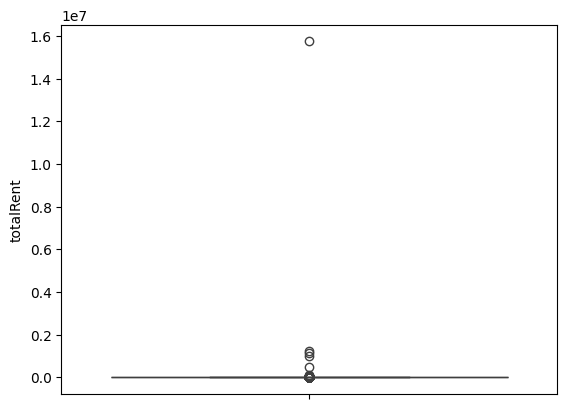

In [ ]:
## Lets examine our target variable, totalRent:

fig=plt.figure()
sns.boxplot(df_new['totalRent'])
plt.show()

It is evident there are some great outliers that need to be removed in order to be effectively predicted.

There are a handful of other numerical variables that present such types of outliers, which need to be individually examined.

In [ ]:
# We will inspect the highest values of some relevant numeric variables with outliers:

high_values = (df_new[(df_new['baseRent'] >= 8000.0)]
                [['baseRent','livingSpace','totalRent','serviceCharge']]
                .sort_values(by=['baseRent','livingSpace'],ascending = [False,True])
                .head(20))
high_values

,baseRent,livingSpace,totalRent,serviceCharge
264934,9999999.00,1.00,NaN,NaN
8406,1234567.00,76.00,1234567.00,NaN
260259,1000000.00,10.00,1000000.00,NaN
16731,120000.00,65.72,NaN,NaN
243713,120000.00,14000.00,NaN,25000.0
181618,39200.00,49.00,NaN,165.0
176647,30990.00,47.67,449.90,78.0
213625,20100.00,110.00,2390.00,140.0
190283,20000.00,566.00,26500.00,6500.0
170816,19329.00,601.85,20588.00,1259.0


In [ ]:
#### It is after the 7th element in the list above that registers start to show reasonable values.
#### Hence, we will eliminate the first 7 elements

df_new.drop(high_values[:7].index,inplace=True)

In [ ]:

high_values2 = (df_new[(df_new['totalRent'] >= 8000.0)]
                [['baseRent','livingSpace','totalRent','serviceCharge']]
                .sort_values(by=['totalRent'],ascending = [False])
                .head(20))
high_values2

,baseRent,livingSpace,totalRent,serviceCharge
239533,1325.00,125.00,15751535.00,250.00
109047,950.00,137.00,1150900.00,200.00
79903,350.00,62.00,485350.00,135.00
23490,820.00,86.61,108000.00,260.00
197378,487.51,79.00,64651.00,159.00
16832,460.29,68.70,63204.00,171.75
97927,427.70,32.90,51570.00,50.00
240954,266.00,49.00,37600.00,110.00
190283,20000.00,566.00,26500.00,6500.00
170816,19329.00,601.85,20588.00,1259.00


In [ ]:
# We do the same to exclude the outliers in totalRent:
df_new.drop(high_values2[:8].index,inplace=True)

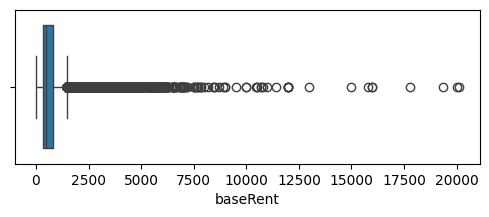

In [ ]:
# Lets inspect important boxplots now
plt.figure(figsize=(6,2))
sns.boxplot(x = df_new['baseRent'])
plt.show()

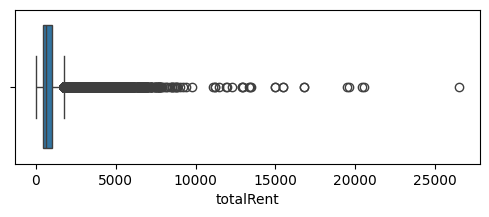

In [ ]:
plt.figure(figsize=(6,2))
sns.boxplot(x = df_new['totalRent'])
plt.show()

In [ ]:
# We explore and remove potential abnormalities like serviceCharge being higher than Rent:
df_new[(df_new['serviceCharge'] >= df_new['baseRent'])][['baseRent','totalRent','serviceCharge','livingSpace']].sort_values(by='totalRent')

,baseRent,totalRent,serviceCharge,livingSpace
232236,10.0,0.0,80.0,0.00
35630,0.0,0.0,0.0,0.00
216231,0.0,0.0,0.0,38.73
121653,0.0,0.0,0.0,62.00
69577,0.0,0.0,1.5,0.00
...,...,...,...,...
207680,0.0,NaN,260.0,115.00
214259,550.0,NaN,730.0,96.00
225352,0.0,NaN,200.0,90.00
263215,100.0,NaN,100.0,17.00


In [ ]:
# remove rows where serviceCharge >= totalRent
df_new = df_new[~(df_new['serviceCharge'] >= df_new['totalRent'])]

In [ ]:
# inspect rows where baseRent > totalRent
df_new[(df_new['baseRent'] > df_new['totalRent'])][['baseRent','totalRent','serviceCharge','livingSpace']].sort_values(by='totalRent')

df_new = df_new[~(df_new['baseRent'] >= df_new['totalRent'])]

#### Handling the Construction Year:

In [ ]:
# There should not be any value past 2024, hence we replace with the median.
df_new.loc[df_new['yearConstructed'] >= 2024, 'yearConstructed'] = df_new['yearConstructed'].median()

## All those values around the year 1100-1200 do not seem to make sense or either be of relevance for our predicitive model.
## We replace with the median of the variable.
df_new.loc[df_new['yearConstructed'] <= 1200, 'yearConstructed'] = df_new['yearConstructed'].median()

 #### Handling outliers in 'floor', 'numberOfFloors', noRooms:

In [ ]:

high_values4 = (df_new[(df_new['numberOfFloors'] >= 100)]
                [['floor','numberOfFloors']]
                .sort_values(by=['numberOfFloors'],ascending = [False])
                .head(20))
high_values4


,floor,numberOfFloors
48498,1.0,999.0
100789,1.0,999.0
72253,0.0,999.0
107377,2.0,800.0
181497,2.0,800.0
262400,2.0,730.0
150943,6.0,600.0
123333,1.0,594.0
202923,3.0,410.0
43275,0.0,378.0


In [ ]:
## Given the more sparsely distributed nature of the outliers, we will proceed to eliminate them using the interquartile range:

# floor:
percentile25 = df_new['floor'].quantile(0.25)
percentile75 = df_new['floor'].quantile(0.75)

iqr = percentile75 - percentile25
upper_limit = round(percentile75 + 1.5 * iqr,0)

df_new.loc[df_new['floor'] > upper_limit, 'floor'] = upper_limit


# numberOfFloors:
percentile25 = df_new['numberOfFloors'].quantile(0.25)
percentile75 = df_new['numberOfFloors'].quantile(0.75)

iqr = percentile75 - percentile25
upper_limit = round(percentile75 + 1.5 * iqr,0)

df_new.loc[df_new['numberOfFloors'] > upper_limit, 'numberOfFloors'] = upper_limit


# Number of Rooms:
percentile25 = df_new['noRooms'].quantile(0.25)
percentile75 = df_new['noRooms'].quantile(0.75)

iqr = percentile75 - percentile25
upper_limit = round(percentile75 + 1.5 * iqr,0)

df_new.loc[df_new['noRooms'] > upper_limit, 'noRooms'] = upper_limit



#### Living Space outliers:

In [ ]:
high_values5 = (df_new[(df_new['livingSpace'] >= 50)]['livingSpace'].sort_values(ascending = [False])
                .head(30))
high_values5

#We will clean outliers with the interquartile range given the smoothness of their distribution:

# floor:
percentile25 = df_new['livingSpace'].quantile(0.25)
percentile75 = df_new['livingSpace'].quantile(0.75)

iqr = percentile75 - percentile25
upper_limit = round(percentile75 + 1.5 * iqr,0)

df_new.loc[df_new['livingSpace'] > upper_limit, 'livingSpace'] = upper_limit


#### Service Charge outliers:

In [ ]:
high_values6 = (df_new[(df_new['serviceCharge'] >= 200)]['serviceCharge'].sort_values(ascending = [False])
                .head(30))
high_values6

#We will clean outliers with the interquartile range given the smoothness of their distribution:

# floor:
percentile25 = df_new['serviceCharge'].quantile(0.25)
percentile75 = df_new['serviceCharge'].quantile(0.75)

iqr = percentile75 - percentile25
upper_limit = round(percentile75 + 1.5 * iqr,0)

df_new.loc[df_new['serviceCharge'] > upper_limit, 'serviceCharge'] = upper_limit


## 1.3. VISUALIZATION AFTER OUTLIER CLEANING
We proceed to see the result of our outlier substraction:


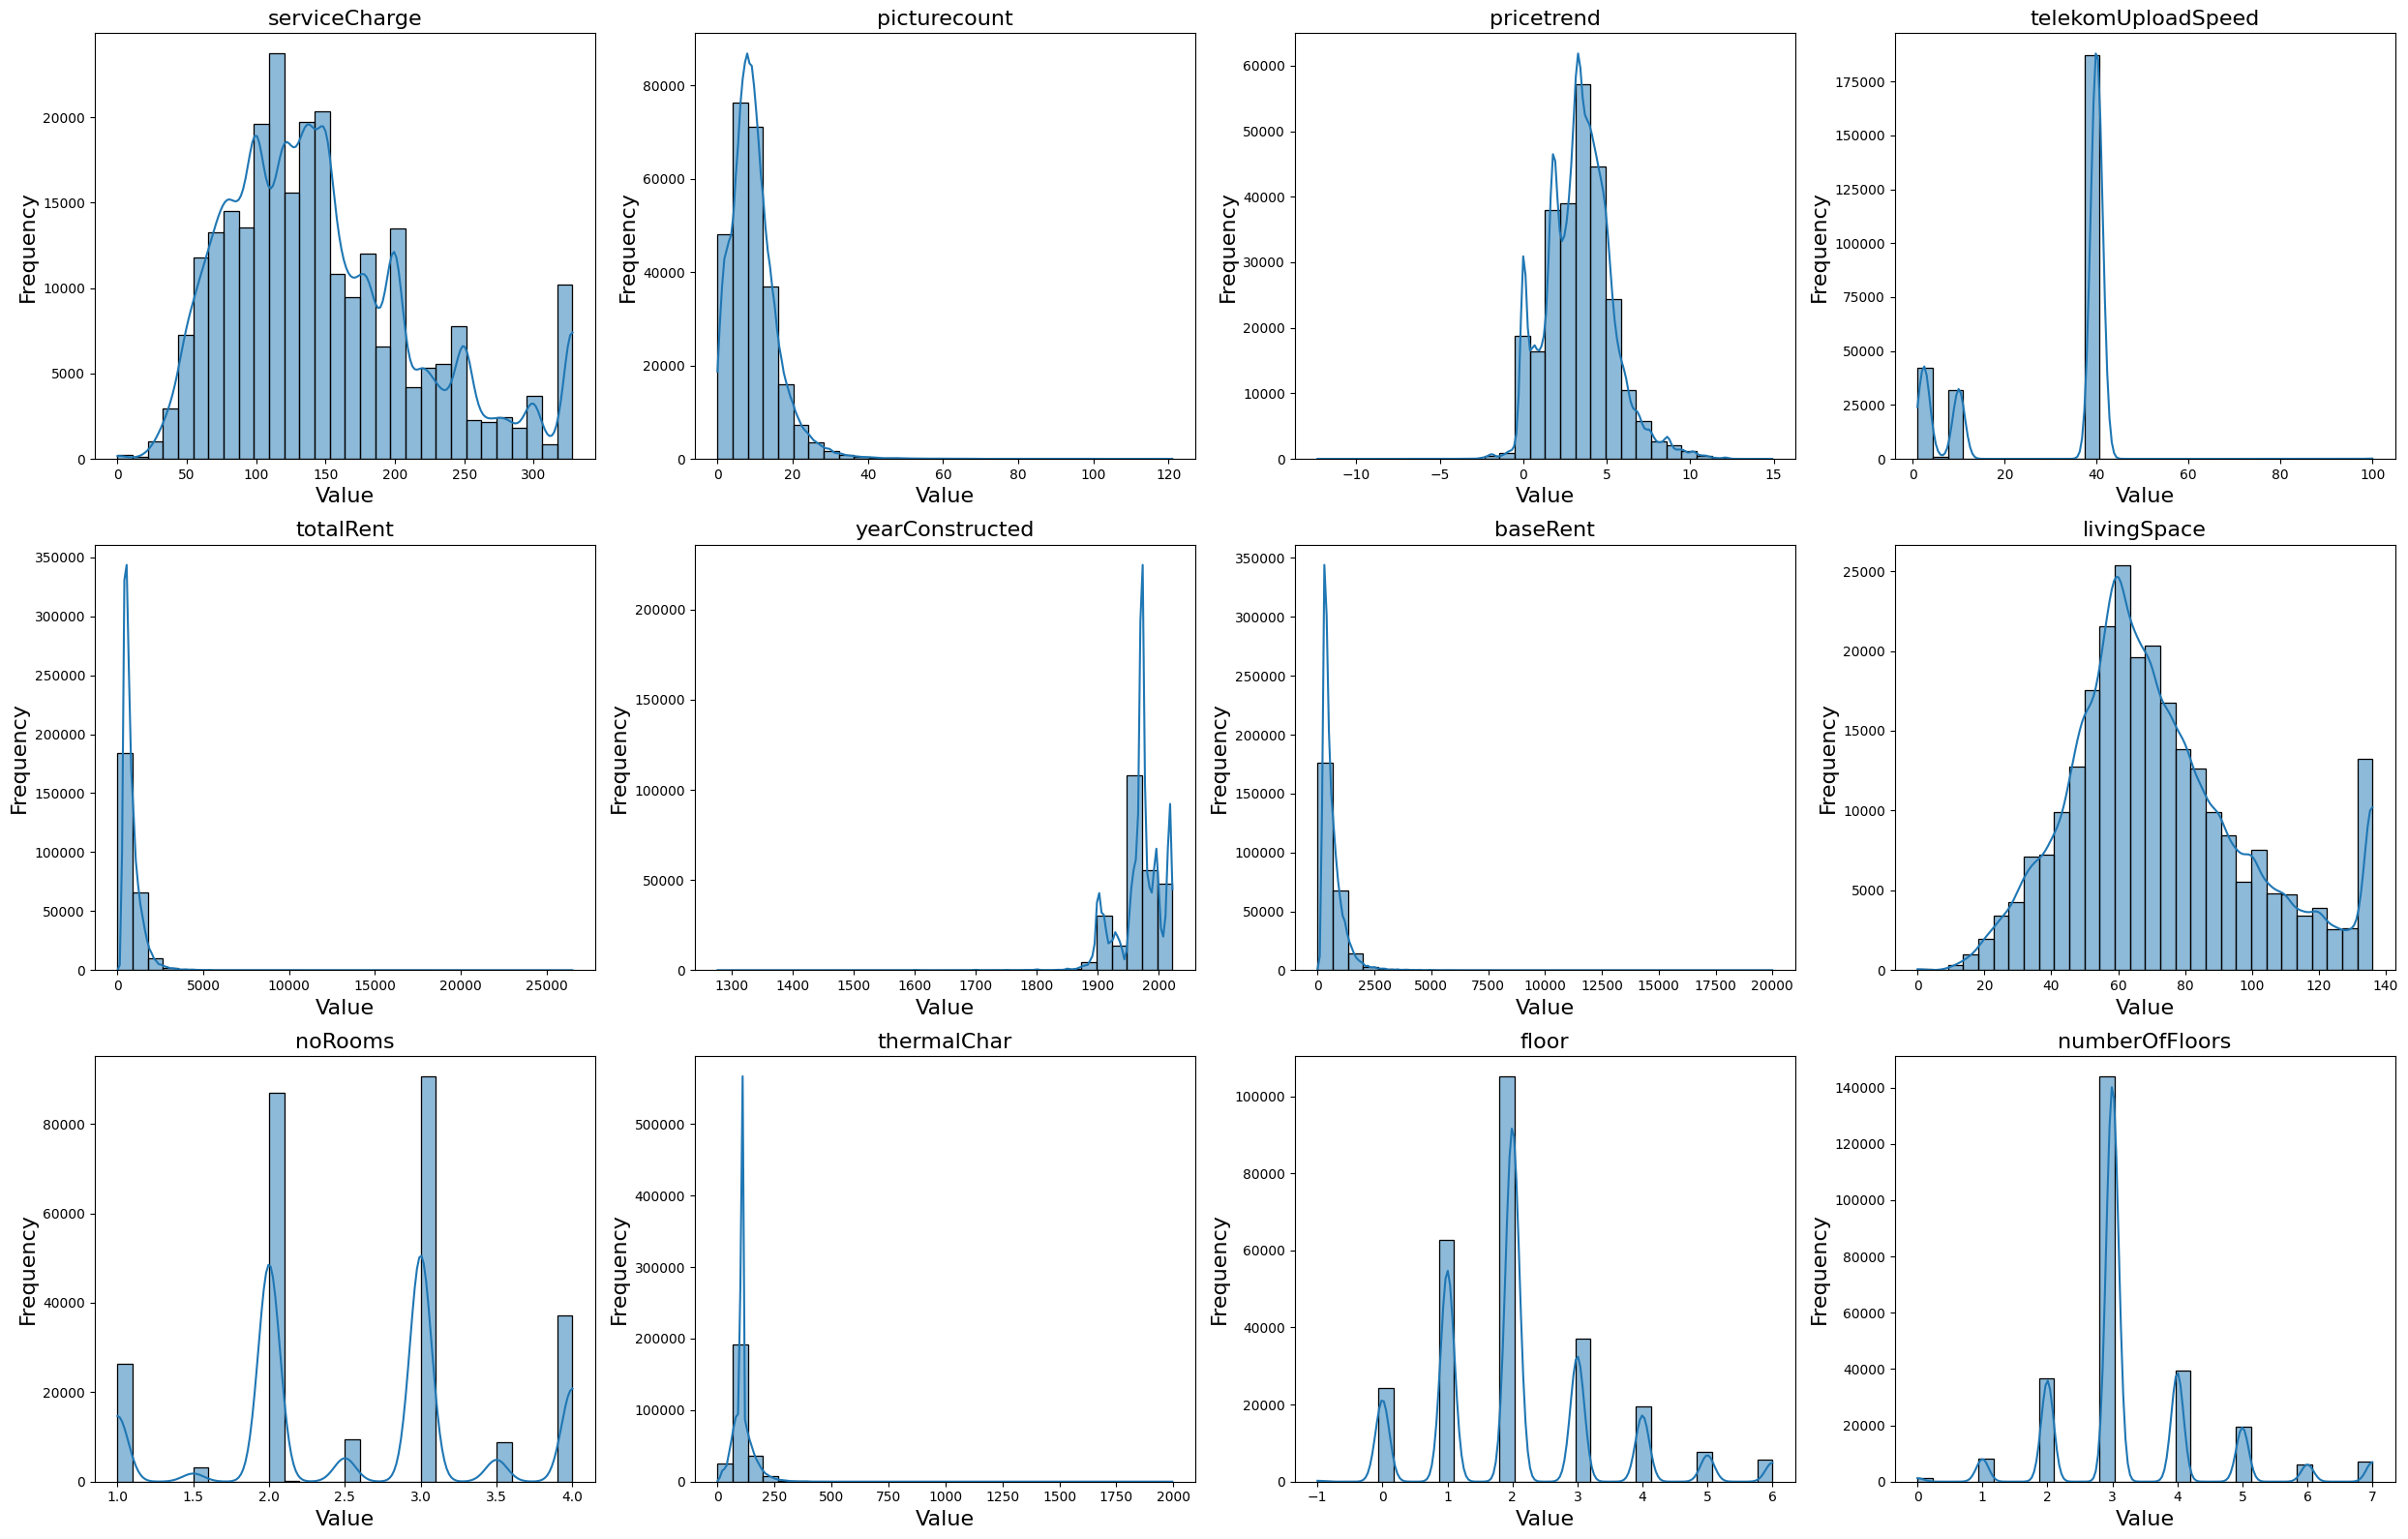

In [ ]:
# Create histograms for numeric variables:
fig, axes =plt.subplots(3, 4, figsize=(25,16))
axes = axes.flatten()

for i, ax in enumerate(axes):
  data = df_new[num[i]]

  sns.histplot(data, bins=30, kde=True, ax=ax)
  ax.set_title(str(num[i]), fontsize=16)
  ax.set_xlabel('Value', fontsize=16)
  ax.set_ylabel('Frequency', fontsize=16)

plt.tight_layout()

plt.savefig(path_files + 'numericalvar_histplot.png')

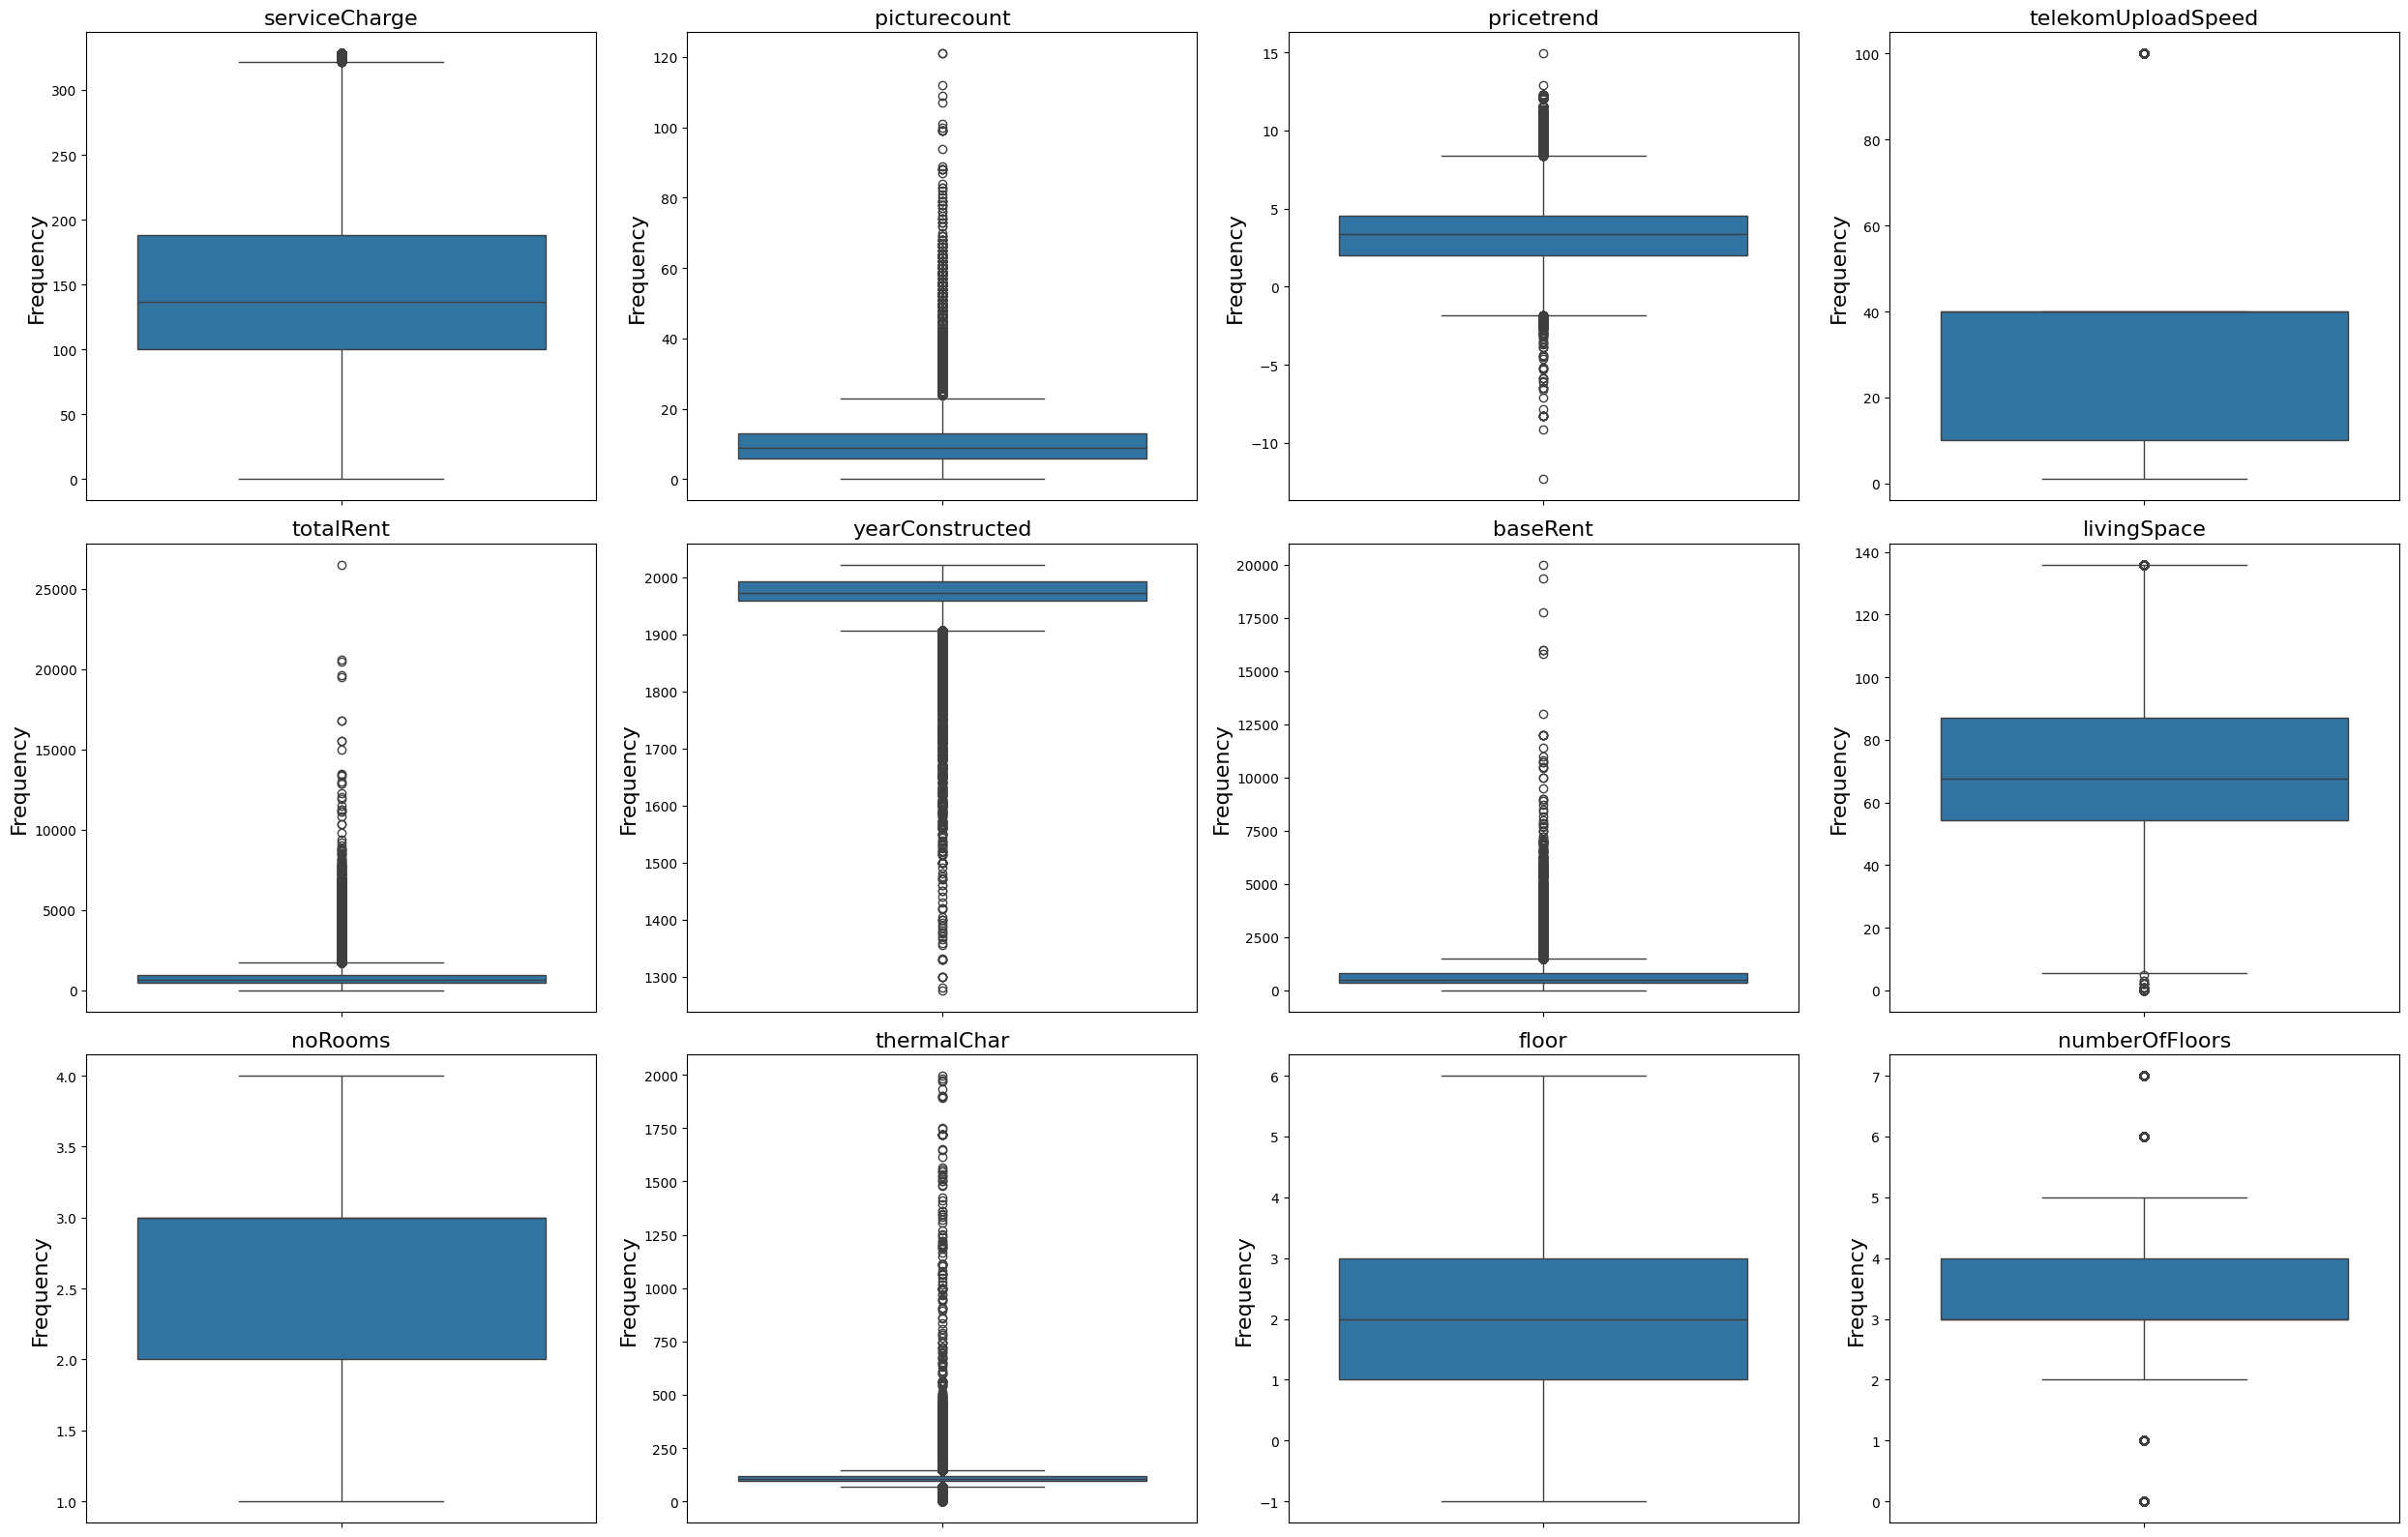

In [ ]:
# Create boxplots for numeric variables:
fig, axes =plt.subplots(3, 4, figsize=(25,16))
axes = axes.flatten()

for i, ax in enumerate(axes):
  data = df_new[num[i]]

  sns.boxplot(data, ax=ax)
  ax.set_title(str(num[i]), fontsize=16)
  ax.set_ylabel('Frequency', fontsize=16)

plt.tight_layout()
plt.savefig(path_files + 'numericalvar_boxplot.png')

In [ ]:
########################

# 1.4. CATEGORICAL VARIABLES: ENCODING

## 1.4.1. Boolean Encoding

Boolean variables will be simply handled through a replacement with 0 and 1's for the False and True categories.

In [ ]:
bool_cols=df_new.select_dtypes(include='bool').columns
df_new[bool_cols + '_encoded']=df_new[bool_cols].astype('Int64')

df_new[bool_cols].describe()

,balcony,hasKitchen,cellar,lift,garden
count,262639,262639,262639,262639,262639
unique,2,2,2,2,2
top,True,False,True,False,False
freq,162172,173755,170013,200969,210970


We have turned 5 boolean variables into numeric values.  
Now we will do the same for other remaining variables that have categories with ordinality, that is, we will turn them into numeric sequences manually.

## 1.4.2. Label Encoding

In [ ]:
## These variables display a certain degree of order which makes them suitable to have their categories replaced by sequential numbers.

### petsAllowed ###

df_new['petsAllowed'].replace(np.nan,'nan', inplace=True)
mapping = {'no': 0,
           'nan': 0,
           'negotiable': 1,
           'yes': 2
           }
df_new['petsAllowed_encoded']=df_new['petsAllowed'].map(mapping)


### condition ####

df_new['condition'].replace(np.nan,'nan', inplace=True)
condition_mapping = {
    'mint_condition': 10,                     # Best for rent price
    'fully_renovated': 9,
    'modernized': 8,
    'refurbished': 7,
    'first_time_use': 6,
    'first_time_use_after_refurbishment': 5,
    'well_kept': 4,
    'negotiable': 3,
    'need_of_renovation': 2,
    'ripe_for_demolition': 1,                 # Worst for rent price
    'nan': 0                                   # Treat missing values as least favorable
}
# Apply the mapping
df_new['condition_encoded'] = df_new['condition'].map(condition_mapping)


### interiorQual ###

df_new['interiorQual'].replace(np.nan,'nan', inplace=True)
interiorqual_mapping = {
    'luxury': 4,                     # Best for rent price
    'sophisticated': 3,
    'normal': 2,
    'simple': 1,
    'nan': 1,
}
# Apply the mapping
df_new['interiorQual_encoded'] = df_new['interiorQual'].map(interiorqual_mapping)


<ipython-input-231-13faa20d9f66>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_new['petsAllowed'].replace(np.nan,'nan', inplace=True)
<ipython-input-231-13faa20d9f66>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

## 1.4.3. Target Encoding:

In [ ]:
# For the remaining categorical variables, we are going to carry out a target encoding.
tar_en_var=['regio1', 'heatingType',
       'houseNumber', 'geo_plz', 'street', 'typeOfFlat',
       'regio2', 'regio3']


target_variable = 'totalRent'



### For the target encoding we need to work with the prediction target variable (totalRent),
### so having it cleaned of its most important outliers was one of the reasons why I took that outlier cleaning step for the numerical variables in advance.
### Otherwise, it could have created a wrong and innacurate scaling for the encoded variables, since their replacement values rely on the totalRent mean in groups of data.

df_new=df_new.reset_index()

from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for col in tar_en_var:
  encoded_col_name= col + '_encoded'
  df_new[encoded_col_name]=0

  # K-fold cross-validation target encoding:

  for train_idx, valid_idx in kf.split(df_new):
    train_data = df_new.iloc[train_idx]
    valid_data = df_new.iloc[valid_idx]

    #Calculate the mean target value for each category in the training set:
    mean_target = train_data.groupby(col)[target_variable].mean()

    #Map the mean target to the validation set:
    df_new.loc[valid_idx, encoded_col_name] = valid_data[col].map(mean_target)

  #Fill NaN values with overall mean of the target variable:
  overall_mean = df_new[target_variable].mean()
  df_new[encoded_col_name].fillna(overall_mean, inplace = True)

####################
## DISCLAIMER: After thinking about it more carefully, choosing the median here for the target encoding in stead of the mean could be more appropiate given that the distribution of 'totalRent' is skewed.
## It is a point of future consideration and improvement.

<ipython-input-232-16137331e819>:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[582.37310889 582.37310889 853.74925258 ... 582.37310889 513.49984598
 513.49984598]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_new.loc[valid_idx, encoded_col_name] = valid_data[col].map(mean_target)
<ipython-input-232-16137331e819>:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_new[encoded_col_name].fillna(o

### 1.5 Filling of missing values in numerical variables


We fill NA for totalRent, our target variable, with BaseRent and ServiceCharge since we expect that total Rent >= baseRent + Service Charge:


In [ ]:
df_new.loc[df_new['totalRent'].isna(),'totalRent'] = df_new['baseRent'] + df_new['serviceCharge']


We use SimpleImputer from scikit-learn.
We use the median in order to make the filling less sensitive to outliers.


In [ ]:
median_imputer = SimpleImputer(strategy='median')
df_new[num] = median_imputer.fit_transform(df_new[num])

So far, we have encoded our categorical variables, replacing NaNs for all of them with means.
We have also replaced NaNs in the numerical variables.

In [ ]:
all_encoded_variables=['balcony_encoded',
       'hasKitchen_encoded', 'cellar_encoded', 'lift_encoded',
       'garden_encoded', 'petsAllowed_encoded', 'condition_encoded',
       'interiorQual_encoded', 'regio1_encoded', 'heatingType_encoded',
       'houseNumber_encoded', 'geo_plz_encoded', 'street_encoded', 'typeOfFlat_encoded',
       'regio2_encoded', 'regio3_encoded']

important_columns=['serviceCharge', 'picturecount','pricetrend','telekomUploadSpeed','totalRent','yearConstructed',
 'baseRent','livingSpace','geo_plz_encoded','noRooms','thermalChar','floor','numberOfFloors','balcony_encoded','hasKitchen_encoded', 'cellar_encoded', 'lift_encoded',
'garden_encoded', 'petsAllowed_encoded', 'condition_encoded','interiorQual_encoded', 'regio1_encoded', 'heatingType_encoded',
'houseNumber_encoded', 'street_encoded', 'typeOfFlat_encoded','regio2_encoded', 'regio3_encoded']

df_new_2=df_new[important_columns]

We check that all the conversions to numerical values for all variables have been done correctly:

In [ ]:
df_new_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262639 entries, 0 to 262638
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   serviceCharge         262639 non-null  float64
 1   picturecount          262639 non-null  float64
 2   pricetrend            262639 non-null  float64
 3   telekomUploadSpeed    262639 non-null  float64
 4   totalRent             262639 non-null  float64
 5   yearConstructed       262639 non-null  float64
 6   baseRent              262639 non-null  float64
 7   livingSpace           262639 non-null  float64
 8   geo_plz_encoded       262639 non-null  float64
 9   noRooms               262639 non-null  float64
 10  thermalChar           262639 non-null  float64
 11  floor                 262639 non-null  float64
 12  numberOfFloors        262639 non-null  float64
 13  balcony_encoded       262639 non-null  Int64  
 14  hasKitchen_encoded    262639 non-null  Int64  
 15  

In [ ]:
cat_list=['balcony_encoded',
       'hasKitchen_encoded', 'cellar_encoded', 'lift_encoded',
       'garden_encoded', 'petsAllowed_encoded', 'condition_encoded',
       'interiorQual_encoded', 'regio1_encoded', 'heatingType_encoded',
       'houseNumber_encoded', 'street_encoded', 'typeOfFlat_encoded',
       'regio2_encoded', 'regio3_encoded']

### 1.6. Create histograms for formerly categorical variables:


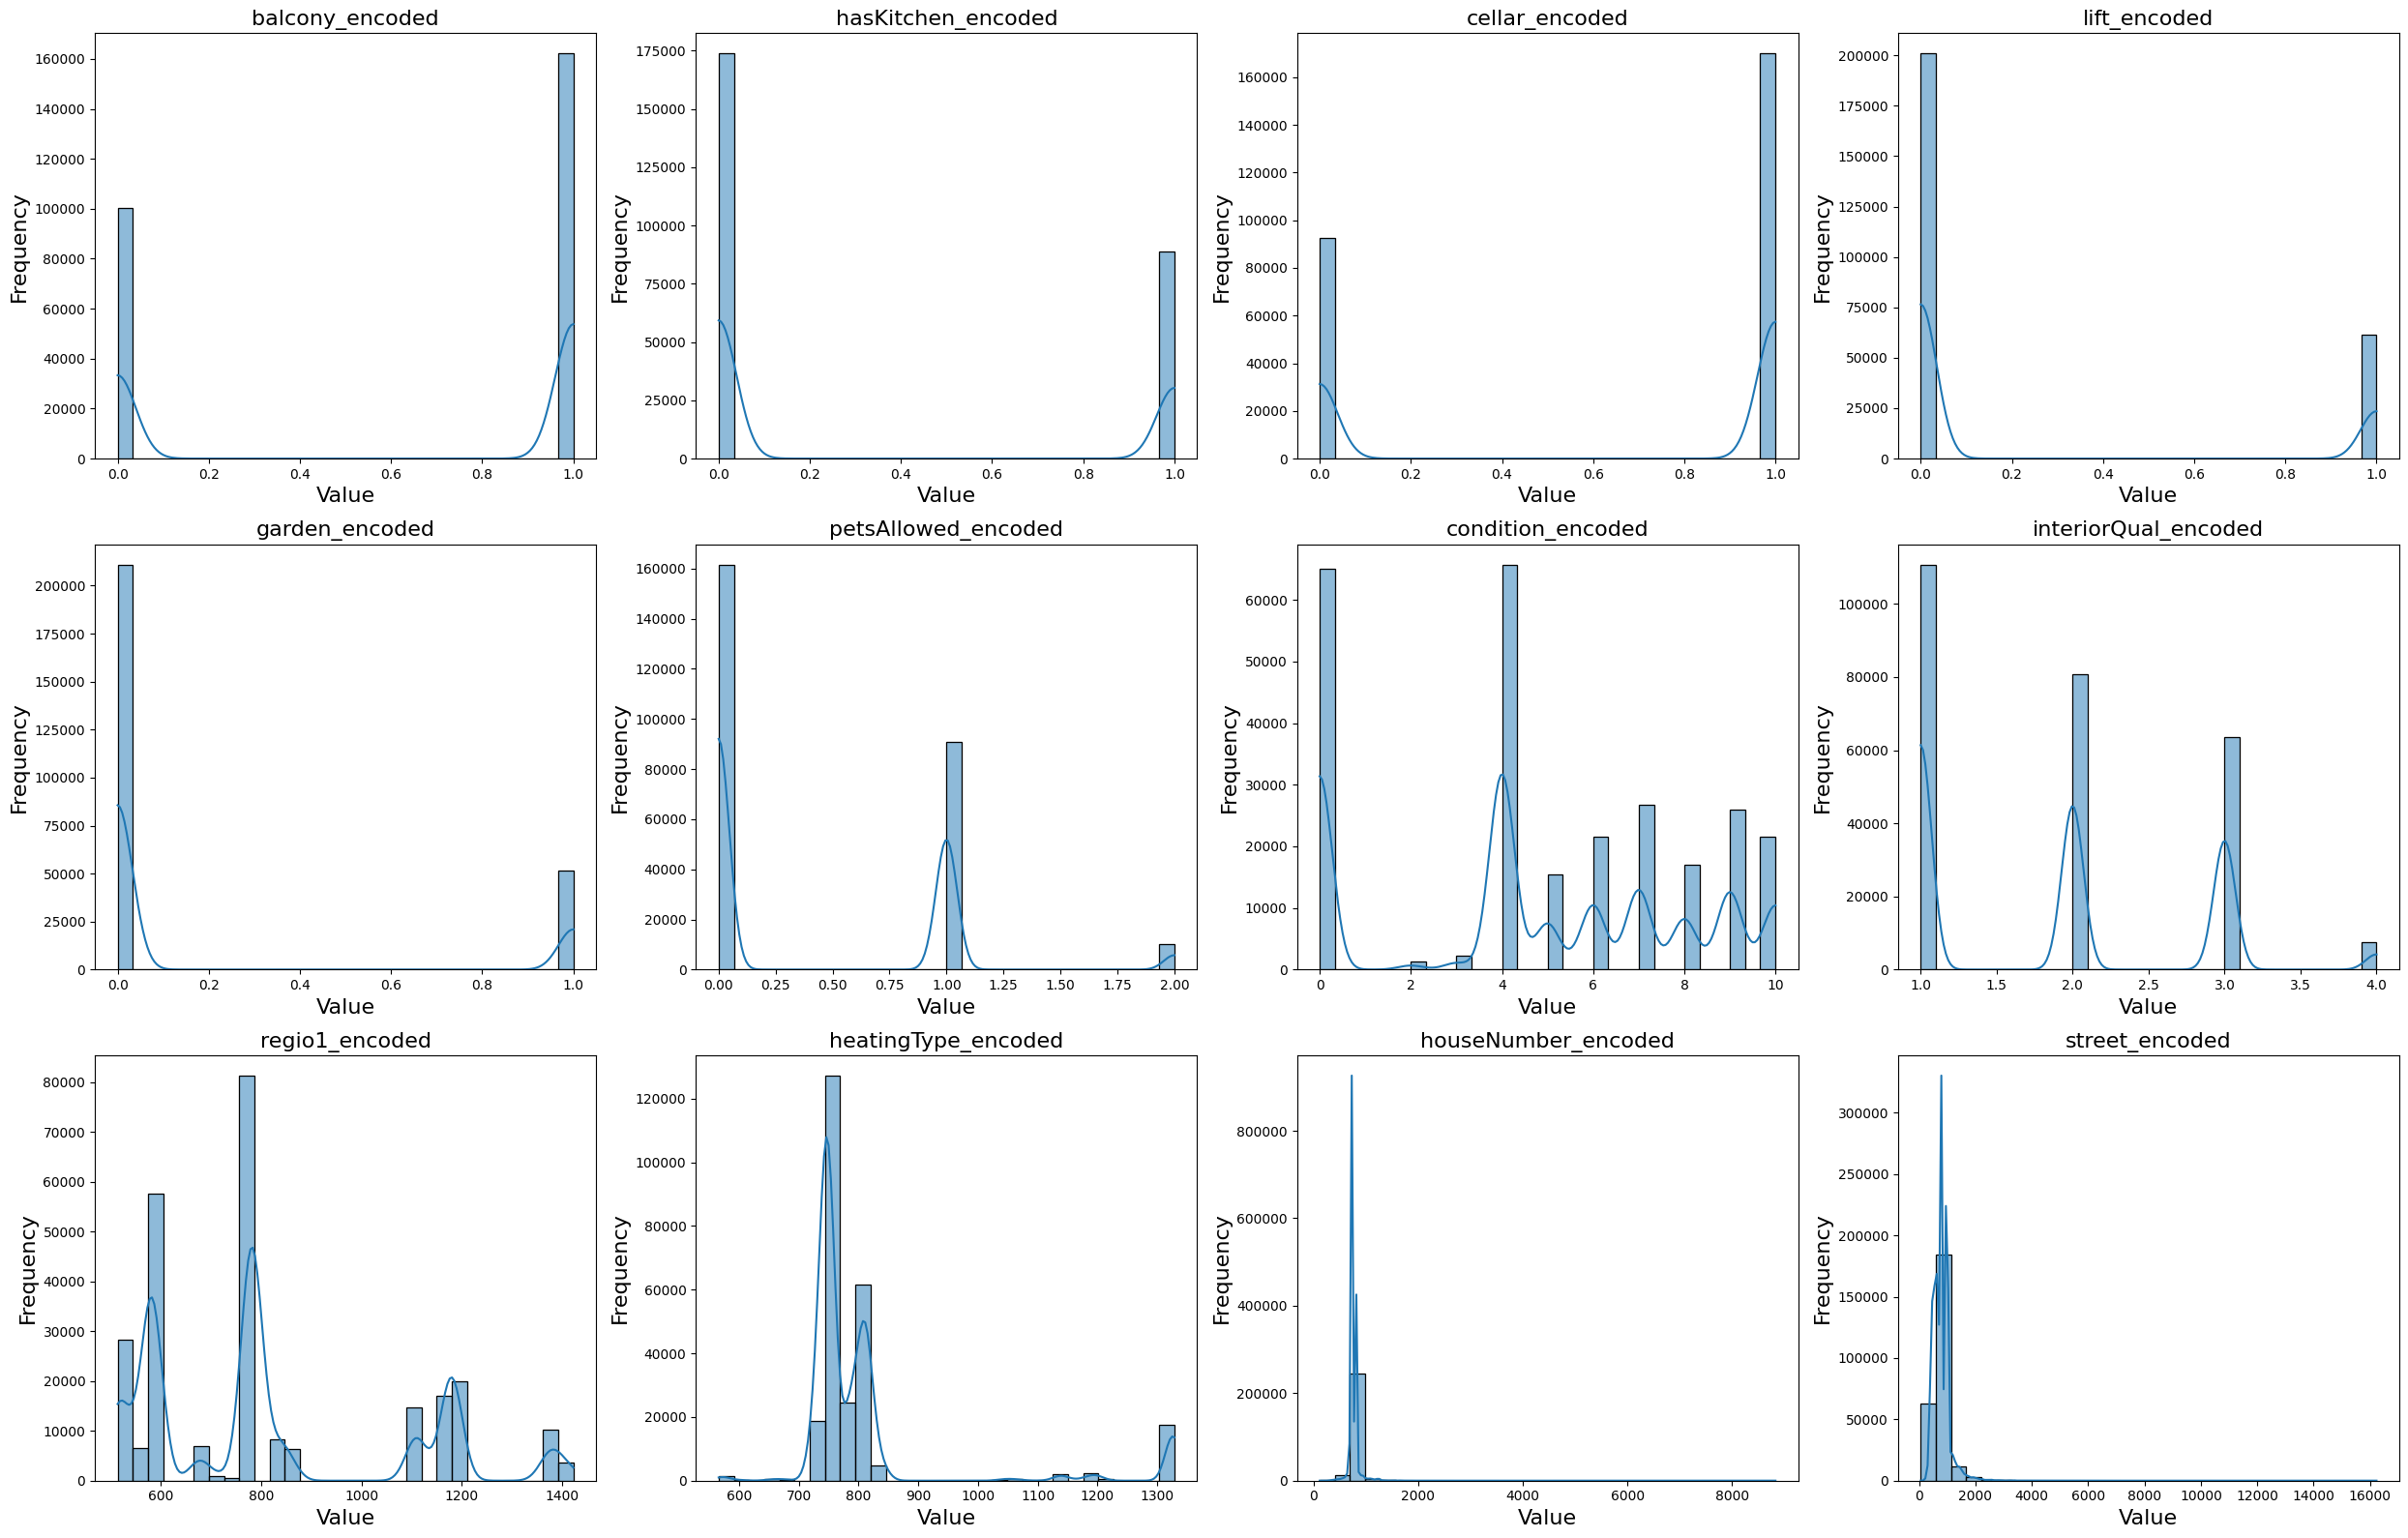

In [ ]:
fig, axes =plt.subplots(3, 4, figsize=(25,16))
axes = axes.flatten()

for i, ax in enumerate(axes):
  data = df_new_2[cat_list[i]]

  sns.histplot(data, bins=30, kde=True, ax=ax)
  ax.set_title(str(cat_list[i]), fontsize=16)
  ax.set_xlabel('Value', fontsize=16)
  ax.set_ylabel('Frequency', fontsize=16)

plt.tight_layout()
plt.savefig(path_files + 'categoricalvar_encoded_histplot.png')

### 1.7. Create histograms for formerly categoric variables:


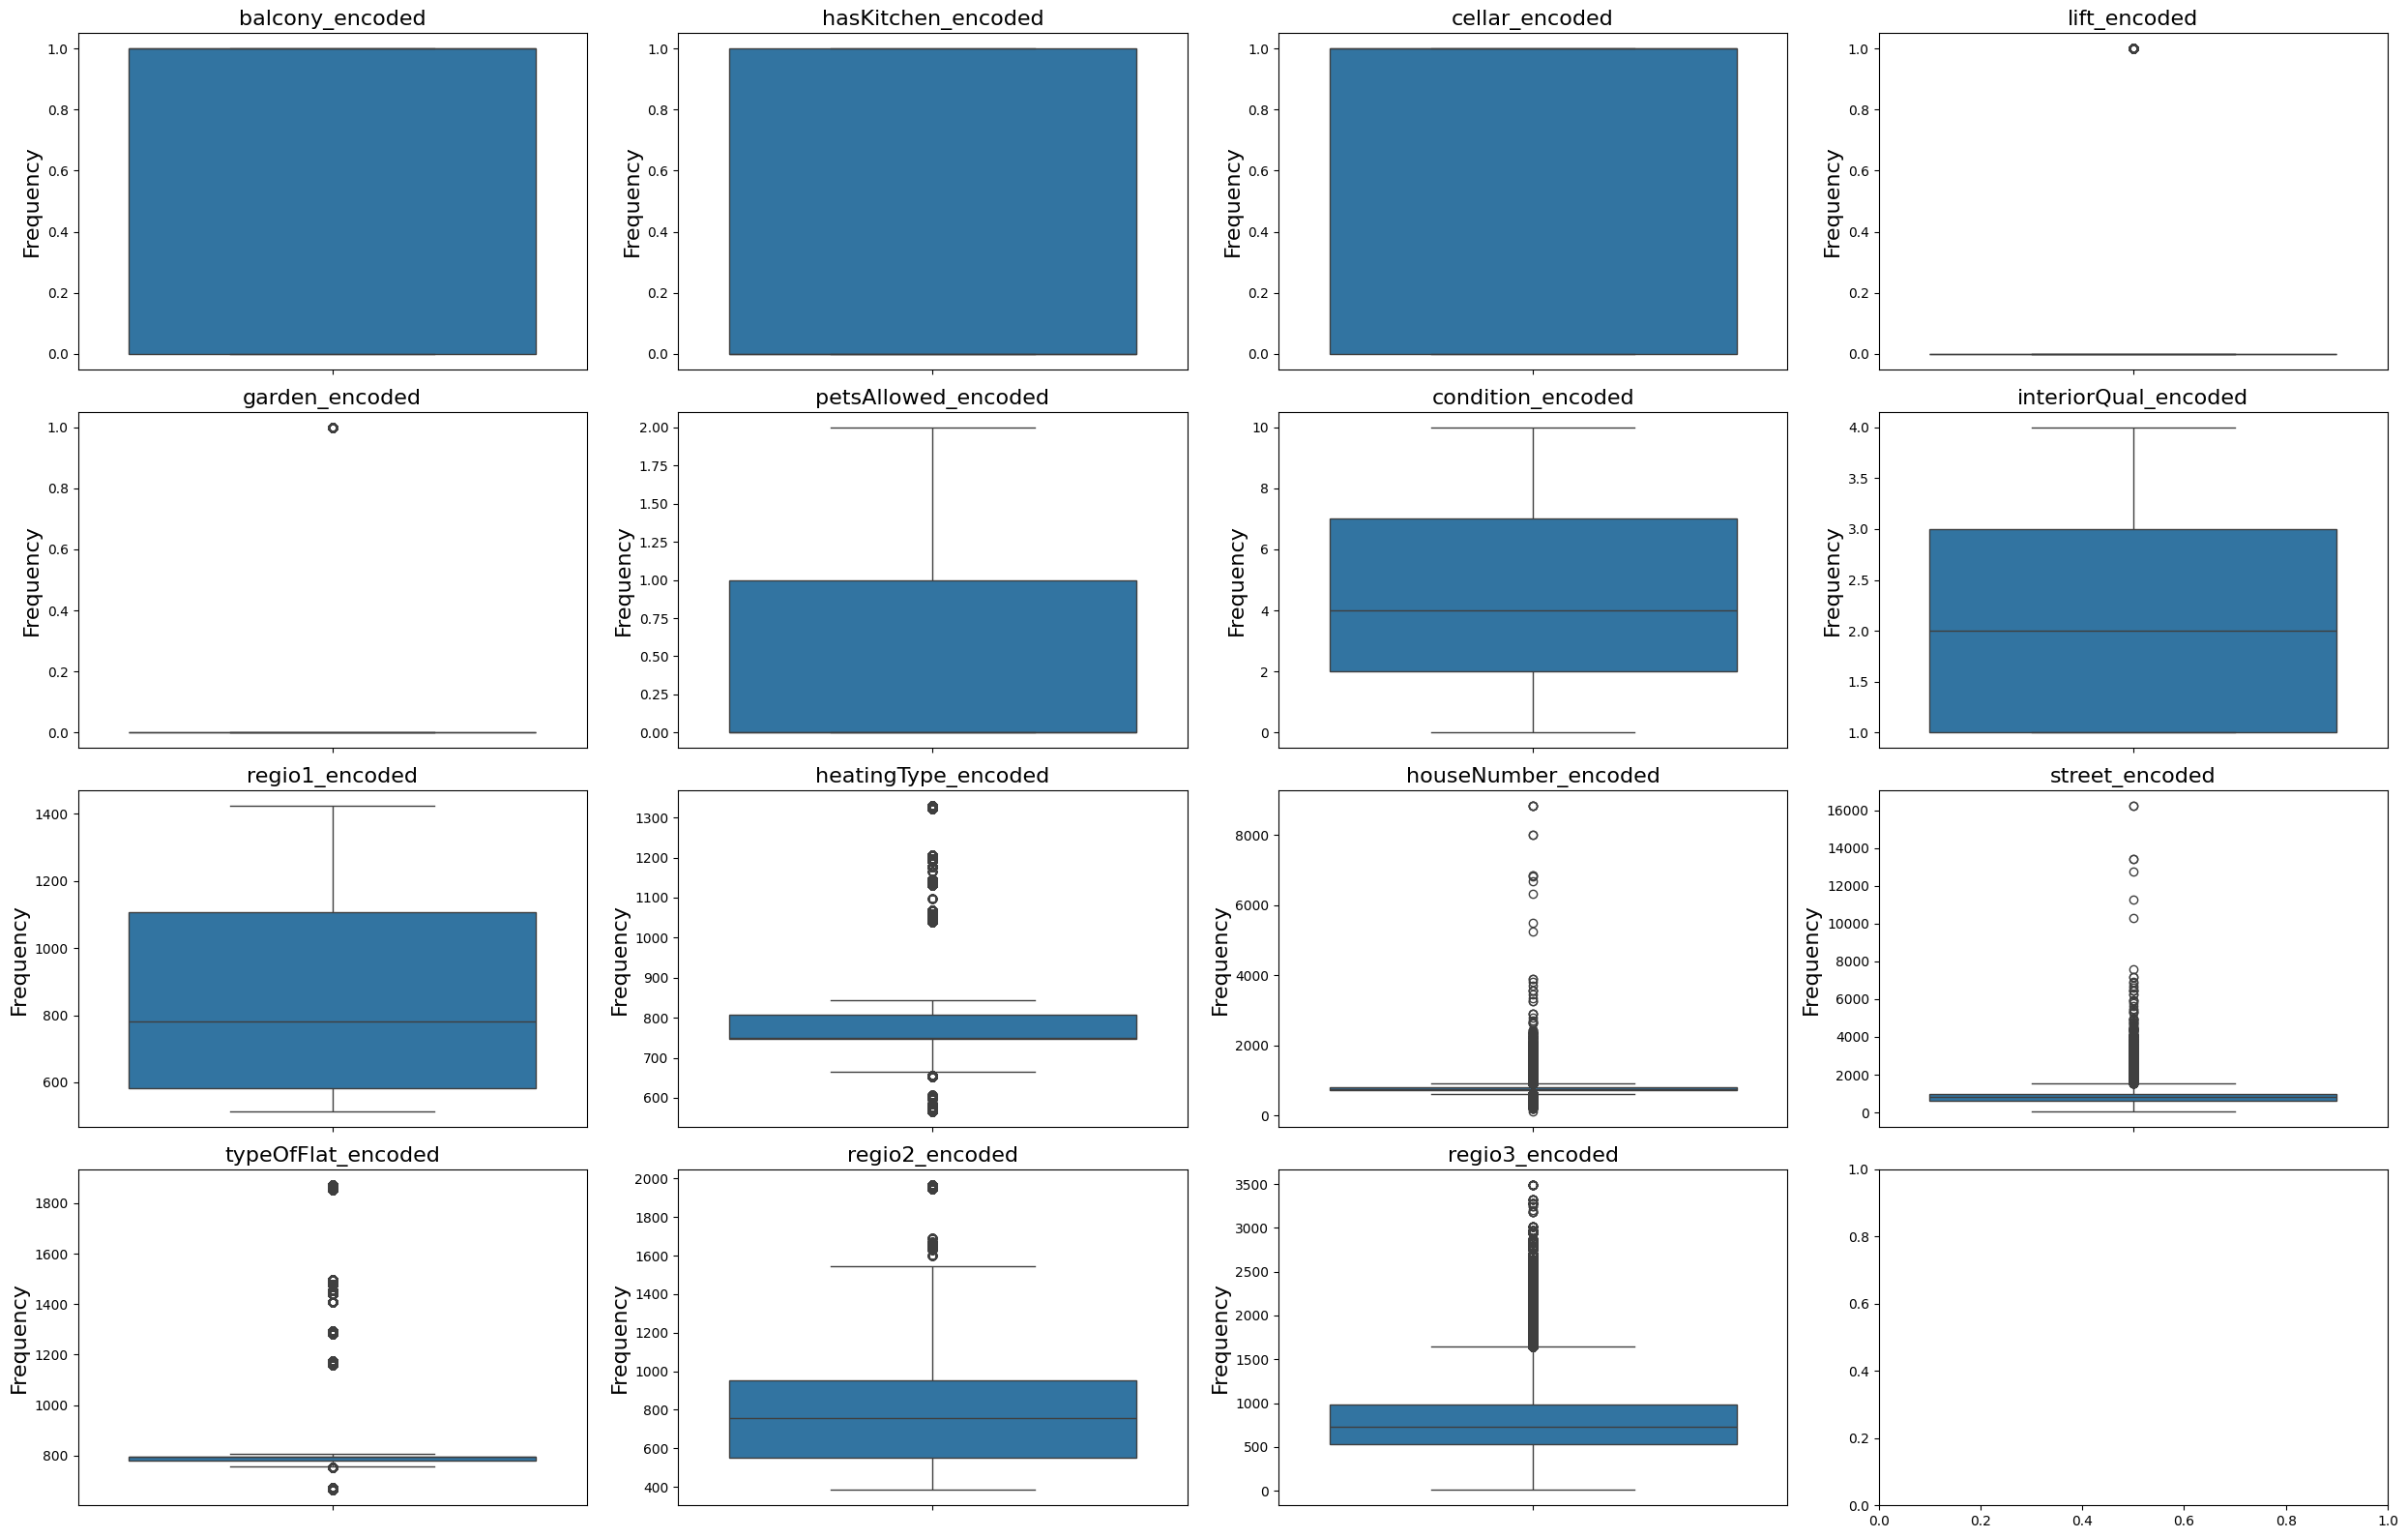

In [ ]:
fig, axes =plt.subplots(4, 4, figsize=(25,16))
axes = axes.flatten()

for i, ax in enumerate(axes):
  try:
    data = df_new_2[cat_list[i]]

    sns.boxplot(data, ax=ax)
    ax.set_title(str(cat_list[i]), fontsize=16)
    ax.set_ylabel('Frequency', fontsize=16)
  except:
    pass
plt.tight_layout()
plt.savefig(path_files + 'categoricalvar_encoded_boxplot.png')

In [ ]:
# df_final=df_new_2[important_columns]
df_final=df_new_2[important_columns]

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262639 entries, 0 to 262638
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   serviceCharge         262639 non-null  float64
 1   picturecount          262639 non-null  float64
 2   pricetrend            262639 non-null  float64
 3   telekomUploadSpeed    262639 non-null  float64
 4   totalRent             262639 non-null  float64
 5   yearConstructed       262639 non-null  float64
 6   baseRent              262639 non-null  float64
 7   livingSpace           262639 non-null  float64
 8   geo_plz_encoded       262639 non-null  float64
 9   noRooms               262639 non-null  float64
 10  thermalChar           262639 non-null  float64
 11  floor                 262639 non-null  float64
 12  numberOfFloors        262639 non-null  float64
 13  balcony_encoded       262639 non-null  int64  
 14  hasKitchen_encoded    262639 non-null  int64  
 15  

We have checked that all our variables are effectively numeric as we intended.
This dataset will be the one to introduce in the prediction model, since it has been preprocessed for NaNs and outliers.

## 1.8. Correlations Heatmap: All (preprocessed) variables

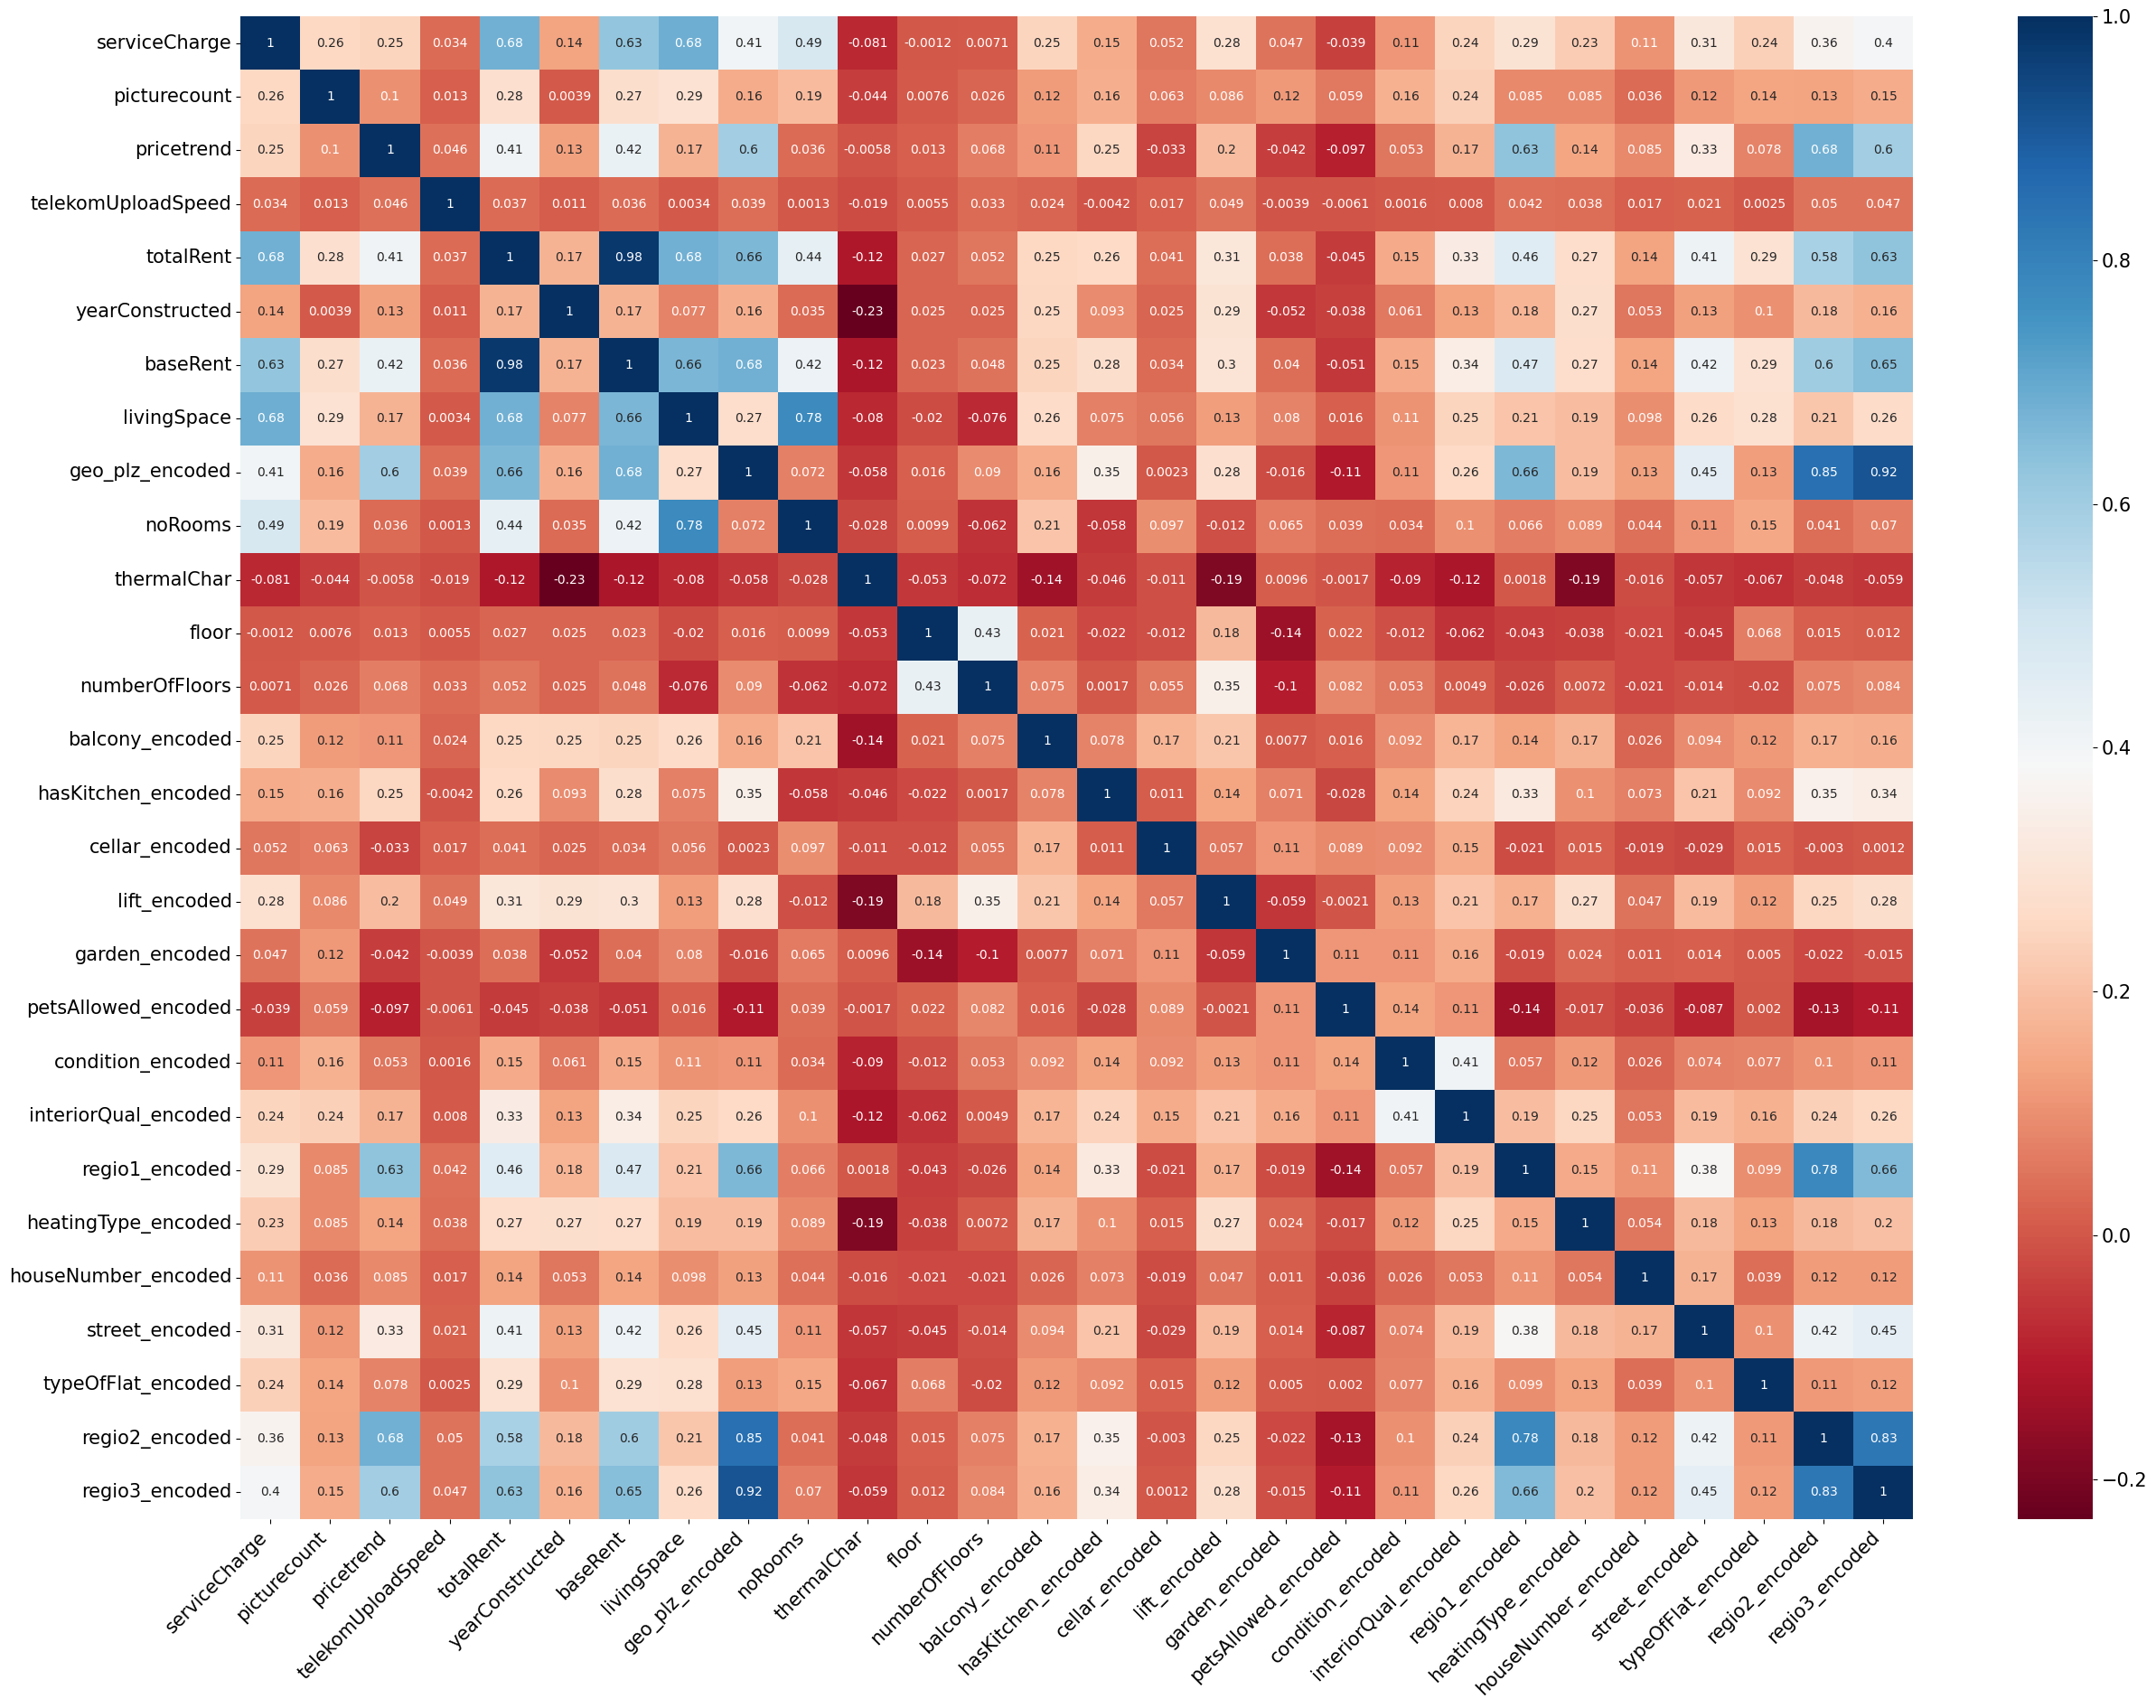

In [ ]:
# for correlations we use the Pearson correlation coefficient

correlations = df_new_2.corr()
f, ax = plt.subplots(figsize=(26, 19))
ax=sns.heatmap(correlations, annot=True, cmap='RdBu', annot_kws={"size":10}, xticklabels=df_new_2.columns, yticklabels=df_new_2.columns);
plt.xticks(rotation=45, ha='right', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)

cbar=ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
plt.tight_layout()
plt.savefig(path_files + 'full_heatmap_correlations.png')

# 1.9. PREDICTION MODEL

We move on to carry out our prediction of the Total Rent based on the dataset. We will separate in training (70%), validation (15%) and test (15%) set. We will train the model with the training set and tune the hyperparameters using the validation set. Later, we will evaluate the model performance using the test set.


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import  train_test_split


In [ ]:
len(df_new)

262639

In [ ]:
df_final.to_csv(path_files + 'df_model1.csv', index=False)

### 1.9.1 Training and Test split:


We choose the standard 80-20 % split for training and test. We do not split a validation set since this will be automatically performed with the cross-validation method.


In [ ]:
X = df_final.drop(['totalRent'], axis=1)
y = df_final['totalRent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 1.9.2 Model inicialization
We create the model and choose a range of hyperparameters to perform the RandomSearch

In [ ]:
xgb_model = XGBRegressor(objective = 'reg:squarederror', random_state=42, n_estimators=100, tree_method='gpu_hist', device='cuda')

param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10, 12],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0,0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5, 1, 5]
}

In [ ]:
!nvidia-smi

Fri Oct 18 00:47:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              55W / 400W |    507MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

### 1.9.3 Random Search with Cross-Validation

We choose a relatively small amount of iterations and folds to produce faster results. The large size of the dataset allows for less folds in the cross-validation with lesser risk of incurring in overfitting.
We choose as the main scoring metric the MAE (mean absolute error) since it is more resistant to outliers, it is easily interpretable, and a commonly used metric.

In [ ]:
random_search = RandomizedSearchCV(estimator=xgb_model,
                                   param_distributions=param_distributions,
                                   n_iter = 20, # Number of params setting to sample
                                   scoring = 'neg_mean_absolute_error',
                                   cv=5, #10-fold cross-validation
                                   verbose=1,
                                   random_state=42,
                                   n_jobs=-1) #To use all available cores


In [ ]:
import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

Fitting the model to the training set.

In [ ]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:40:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device='cuda',
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rat...
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 10, 12],
                                        'n_estimators': [100, 200, 300],
                                        'reg_lambda': [0, 0.1, 0.5, 1, 5],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)

We store the best model to be able to predict with it.

In [ ]:
best_model=random_search.best_estimator_

In [ ]:
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

First scores from the random search tunned model:

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_pred, y_test)
r2= r2_score(y_pred, y_test)

print(f"Best parameters: {random_search.best_params_}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

Best parameters: {'subsample': 0.8, 'reg_lambda': 0, 'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 1.0}
Mean Squared Error: 28.111825100343612
R² Score: 0.9031624647393955


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:43:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


*** Disclaimer: There is a little repetitive error when I display the results, which I corrected. The value that on screen says 'Mean Squared Error' is actually the 'Mean Absolute Error'. It was label as mse for the most part of my work since I doubted wether to show one or the other. I have corrected the name in the code, but the show output still remains as MSE in several parts, since I did not run the code again to correct it. Ultimately, it is the MAE that is being displayed.

Predictions: [1164.149   1674.71     459.75198 ... 1306.3928   454.6397   537.71027]
Test values: [1154.18 1488.    482.   ... 1300.    400.    490.  ]
Prediction Error: [  9.96904785 186.70996094 -22.24801636 ...   6.39282227  54.63970947
  47.71026611]


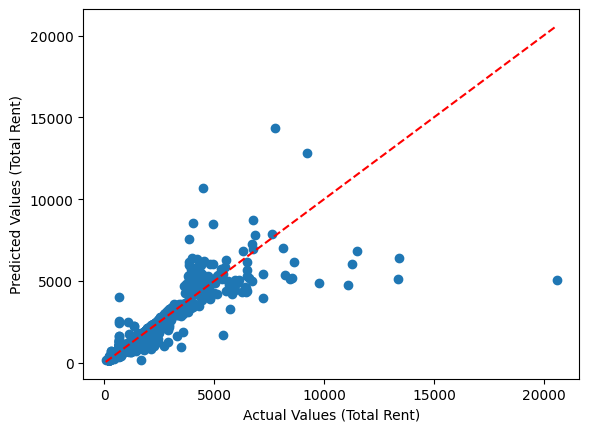

In [ ]:
print ("Predictions:", y_pred)
print ("Test values:", y_test.values)
print ("Prediction Error:", y_pred - y_test.values)
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values (Total Rent)')
plt.ylabel('Predicted Values (Total Rent)')
plt.show()

### 1.9.4 GridSearch to improve the hyperparameters selection

Now we move on to tune our hyperparameters search further with GridSearchCV

In [ ]:
best_params=random_search.best_params_

In [ ]:
best_params

{'subsample': 0.8,
 'reg_lambda': 0,
 'n_estimators': 100,
 'max_depth': 12,
 'learning_rate': 0.1,
 'gamma': 0.5,
 'colsample_bytree': 1.0}

In [ ]:
## We choose the new grid based on the previous results.

param_grid = {
    'n_estimators': [100,150,300],
    'max_depth': [12],
    'learning_rate': [0.08, 0.1, 0.12],
    'subsample': [0.8],
    'colsample_bytree': [1.0],
    'gamma': [0.5, 0.55],
    'reg_lambda': [0, 0.2]
}

I have not tried many more combinations and wider ranges due to lack of available time to explore the parameter space more in depth.

In [ ]:
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1,
    n_jobs=-1
    )

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:15:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device='cuda',
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [1.0], 'gamma': [0.5, 0.55],
                         'learning_rate': [0.08, 0.1, 0.12], 'max_depth': [12],
                         'n_estimators': [100, 150, 300],
                         'reg_lambda': [0, 0.2], 'subsample': [0.8]},
             scoring='neg_mean_absolute_error', verbose=1)

In [ ]:
best_params_final1= grid_search.best_params_
best_score_final1 = grid_search.best_score_

print ("Best Parameters:", best_params_final1)

## Since we chose the MAE, we turn the negative MAE back to positive:
print ("Best MAE from GridSearchCV:", -best_score_final1)


Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0.55, 'learning_rate': 0.08, 'max_depth': 12, 'n_estimators': 300, 'reg_lambda': 0.2, 'subsample': 0.8}
Best MAE from GridSearchCV: 26.47539481723619


In [ ]:
best_model_final1=grid_search.best_estimator_

y_pred_final1 = best_model_final1.predict(X_test)
mae_final1 = mean_absolute_error(y_pred_final1, y_test)
r2_final1= r2_score(y_pred_final1, y_test)

#print(f"Best parameters: {loaded_model.best_params_}")
print(f"Mean Absolute Error (after GridSearchCV): {mae_final1}")
print(f"R² Score (after GridSearchCV): {r2_final1}")

Mean Squared Error (after GridSearchCV): 27.066948858093205
R² Score (after GridSearchCV): 0.9071333632428064


In summary, the model after a slight tunning with GridSearchCV on top of the hyperparameter selection from RandomSearchCV has improved slightly:
from R² 0.903 to 0.907.

The result is satisfactory, yet further iteration must be done, extending the ranges for every hyperparameter as well as the number of Cross-Validation folds, iterations and parameter combinations. This way, we expect to appreciate a greater improvement in the R² values and between both parameter searches.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## We save the model:
joblib.dump(best_model_final1, path_files + 'xgb_model_case1_GSCV.pkl')

### We test the model loading ###

loaded_model = joblib.load(path_files + 'xgb_model_case1_GSCV.pkl')


y_pred_final1 = loaded_model.predict(X_test)
mae_final1 = mean_absolute_error(y_pred_final1, y_test)
r2_final1= r2_score(y_pred_final1, y_test)

#print(f"Best parameters: {loaded_model.best_params_}")
print(f"Mean Absolute Error: {mae_final1}")
print(f"R² Score: {r2_final1}")

Mean Squared Error: 27.066948858093205
R² Score: 0.9071333632428064


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:27:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


# CASE 2: PREDICTIVE MODEL INCLUDING TEXT DATA

We upload the sentiment analysis file produced with Generative AI through the CHAT GPT API

In [ ]:
sentiment = pd.read_csv(path_files + + 'sentiment_analysis_finalversion.txt', on_bad_lines='skip')

print ('added columns from text analysis:', list(sentiment.columns))
print ('number of rows with sentiment extracted:', np.shape(sentiment)[0])

sentiment['original_index'] = sentiment['original_index'].astype('Int64')

Regarding the 'sentiment' dataset:
- I carried out a sentiment analysis from the text variables 'description' and 'facilities' using the API of Chat GPT through Python. The full code is saved in a different notebook.
- I only worked with rows where both text fields were filled, dismissing rows with only one text variable value provided.
- The model took a couple of days to finish running, and stopped shortly before completing the analysis on the full original dataset (268000 rows in size, reduced to ~ 204000 after filtering out rows with one or both of the text variables empty).
- Although most of the times the prompt was understood correctly, some of the query results (one per row in the dataset) yielded some random errors, like for example, not providing all the information I requested. For the sake of completitude and homogeneity, I dismissed those rows for this task (during the upload of the dataset in the line above, with on_bad_lines='skip').

Hence, I will develop the model with the sentiment analysis information on the rows where I obtained complete data.

*** SENTIMENT ANALYSIS:
I seeked to descipher the texts looking for characteristics related to habitability of the properties. I asked Chat GPT through the API to provide me with 6 parameters, rated from 0 to 9: luxury, tranquility, safety, accesibility, security and overall_sentiment.

We merge the sentiment dataframe  with the general dataframe (after preprocessing for outliers and NaNs).

In [ ]:
merge_df = pd.merge(df_new, sentiment, on='original_index', how='inner')

merge_df['overall_sentiment']=pd.to_numeric(merge_df['overall_sentiment'], errors='coerce')
merge_df['luxury']=pd.to_numeric(merge_df['luxury'], errors='coerce')
merge_df['accessibility']=pd.to_numeric(merge_df['accessibility'], errors='coerce')
merge_df['security']=pd.to_numeric(merge_df['security'], errors='coerce')
merge_df['safety']=pd.to_numeric(merge_df['safety'], errors='coerce')
merge_df['tranquility']=pd.to_numeric(merge_df['tranquility'], errors='coerce')

In [ ]:
## We have added the new sentiment variables to the 'important variables':

important_columns=['serviceCharge', 'picturecount','pricetrend','telekomUploadSpeed','totalRent','yearConstructed',
 'baseRent','livingSpace','geo_plz_encoded','noRooms','thermalChar','floor','numberOfFloors','balcony_encoded','hasKitchen_encoded', 'cellar_encoded', 'lift_encoded',
'garden_encoded', 'petsAllowed_encoded', 'condition_encoded','interiorQual_encoded', 'regio1_encoded', 'heatingType_encoded',
'houseNumber_encoded', 'street_encoded', 'typeOfFlat_encoded','regio2_encoded', 'regio3_encoded', 'accessibility','security','luxury','safety','tranquility','overall_sentiment']

df_final_2=merge_df[important_columns]

### 2.2 Sentiment Variables Heatmap
We examine the relationship between the new variables and the target variable. These variables come already encoded, so they are read to be implemented in the new prediction model.


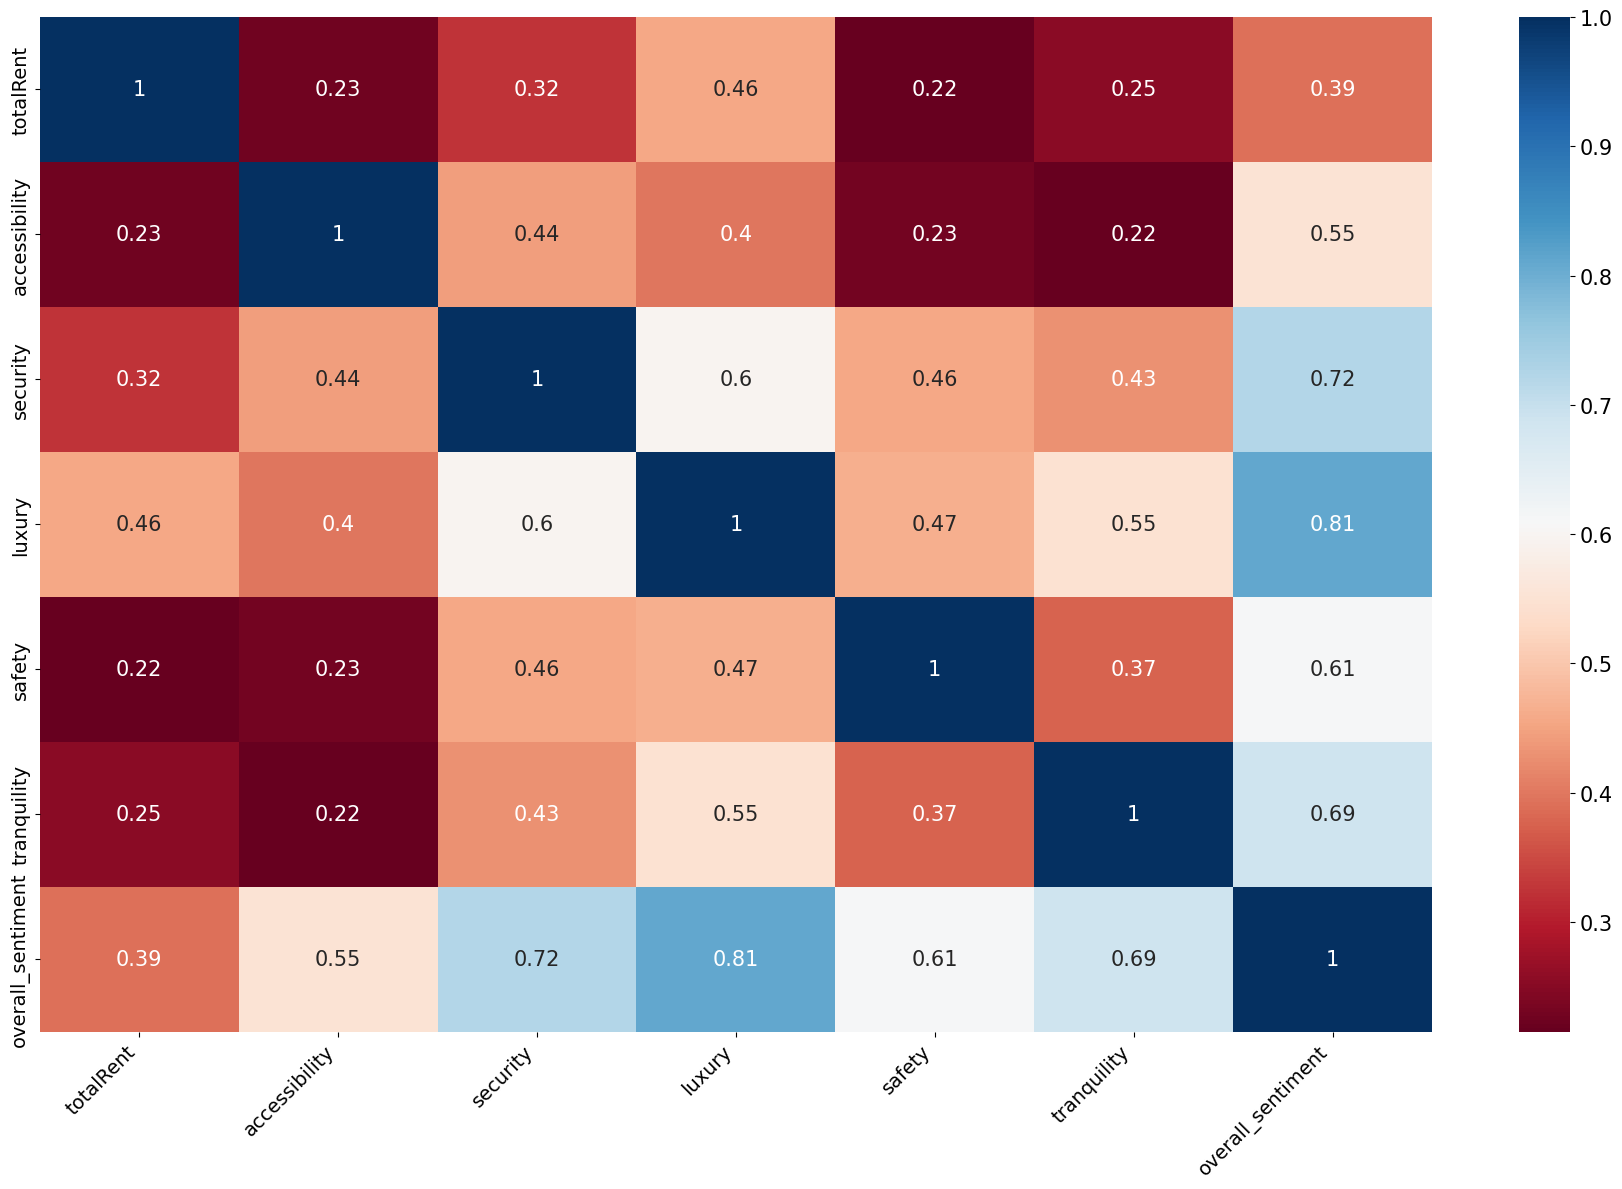

In [ ]:
# Pearson coefficient correlations
subset=merge_df[['totalRent','accessibility','security','luxury','safety','tranquility','overall_sentiment']]
correlations = subset.corr()
f, ax = plt.subplots(figsize=(18, 12))
ax=sns.heatmap(correlations, annot=True, cmap='RdBu', annot_kws={"size":15}, xticklabels=subset.columns, yticklabels=subset.columns);
plt.xticks(rotation=45, ha='right', fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)

cbar=ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
plt.tight_layout()
plt.savefig(path_files + 'heatmap_sentiment_totalRent.png')

In [ ]:
#We save the dataset to be able to use it with a quick script later:
df_final_2.to_csv(path_files + 'df_model2.csv', index=False)

Interestingly, we find that the totalRent is more correlated to the 'luxury' variable than to the 'overall_sentiment', although not by far.
All new sentiment variables show a certain degree of correlation with the Rent. While individually these values are poor, they may improve the overall prediction with only structural variables.


## 2.3 Prediction Model for Case 2

### 2.3.1 Training and Test Splits


In [ ]:
X_2 = df_final_2.drop(['totalRent'], axis=1)
y_2 = df_final_2['totalRent']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)


### 2.3.2 Model inicialization

In [ ]:
xgb_model_2 = XGBRegressor(objective = 'reg:squarederror', random_state=42, n_estimators=100, tree_method='gpu_hist', device='cuda')

param_distributions_2 = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10, 12],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0,0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5, 1, 5]
}

### 2.3.3 RandomSearchCV

In [ ]:
random_search_2 = RandomizedSearchCV(estimator=xgb_model_2,
                                   param_distributions=param_distributions_2,
                                   n_iter = 20, # Number of params setting to sample
                                   scoring = 'neg_mean_absolute_error',
                                   cv=5, #10-fold cross-validation
                                   verbose=1,
                                   random_state=42,
                                   n_jobs=-1) #To use all available cores

random_search_2.fit(X_train_2, y_train_2)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:26:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device='cuda',
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rat...
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 10, 12],
                                        'n_estimators': [100, 200, 300],
                                        'reg_lambda': [0, 0.1, 0.5, 1, 5],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)

In [ ]:
best_model_2=random_search_2.best_estimator_

y_pred_2 = best_model_2.predict(X_test_2)
mae_2 = mean_absolute_error(y_pred_2, y_test_2)
r2_2= r2_score(y_pred_2, y_test_2)

print(f"Best parameters: {random_search_2.best_params_}")
print(f"Mean Absolute Error: {mae_2}")
print(f"R² Score: {r2_2}")

Best parameters: {'subsample': 0.8, 'reg_lambda': 5, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 1.0}
Mean Squared Error: 27.64998256756364
R² Score: 0.947948144154119


Results seem better according to R², though MAE seems slightly higher.

### 2.3.4 GridSearchCV
This time, we carry a very small fine tunning, since not only does R² display good values, but mainly due to time requirements.

In [ ]:



param_grid_2 = {
    'n_estimators': [300,320],
    'max_depth': [10],
    'learning_rate': [0.05],
    'subsample': [0.8],
    'colsample_bytree': [1.0],
    'gamma': [0.5, 0.55],
    'reg_lambda': [5, 5.2]
}


grid_search_2 = GridSearchCV(
    estimator=xgb_model_2,
    param_grid=param_grid_2,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1,
    n_jobs=-1
    )

grid_search_2.fit(X_train_2, y_train_2)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:03:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device='cuda',
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [1.0], 'gamma': [0.5, 0.55],
                         'learning_rate': [0.05], 'max_depth': [10],
                         'n_estimators': [300, 320], 'reg_lambda': [5, 5.2],
                         'subsample': [0.8]},
             scoring='neg_mean_absolute_error', verbose=1)

In [ ]:
best_model_final2=grid_search_2.best_estimator_

y_pred_final2 = best_model_final2.predict(X_test_2)
mae_final2 = mean_absolute_error(y_pred_final2, y_test_2)
r2_final2= r2_score(y_pred_final2, y_test_2)

#print(f"Best parameters: {loaded_model.best_params_}")
print(f"Mean Absolute Error (after GridSearchCV): {mae_final2}")
print(f"R² Score (after GridSearchCV): {r2_final2}")

Mean Squared Error (after GridSearchCV): 27.59981093741188
R² Score (after GridSearchCV): 0.9485026288601618


In [ ]:
print(f"Best parameters: {grid_search_2.best_params_}")


Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 320, 'reg_lambda': 5, 'subsample': 0.8}


Results after GridSearchCV have become slightly better, which is what we would expect after working with narrower ranges. However, the potential for improvement and generalization of the model is much greater if we increase the number of hyperparameter combinations, iterations and CV folds.

In [ ]:
## SAVING THE MODEL:

joblib.dump(best_model_final2, path_files + 'xgb_model_case2_GSCV.pkl')

['/content/gdrive/MyDrive/Colab Notebooks/Zoi_Task/xgb_model_case2_GSCV.pkl']

We store the predictions of both models (with only structural data (M1) and with both structural and text data (M2)) in a data frame


In [ ]:
df_predictions_2 = pd.DataFrame({'Actual_2': y_test_2, 'Predicted': y_pred_final2})
df_predictions_1 = pd.DataFrame({'Actual_1': y_test, 'Predicted': y_pred_final1})

df_predictions_1.to_csv(path_files + 'df_predictions_Model1.csv')
df_predictions_2.to_csv(path_files + 'df_predictions_Model2.csv')

## Lets plot the results together for both models

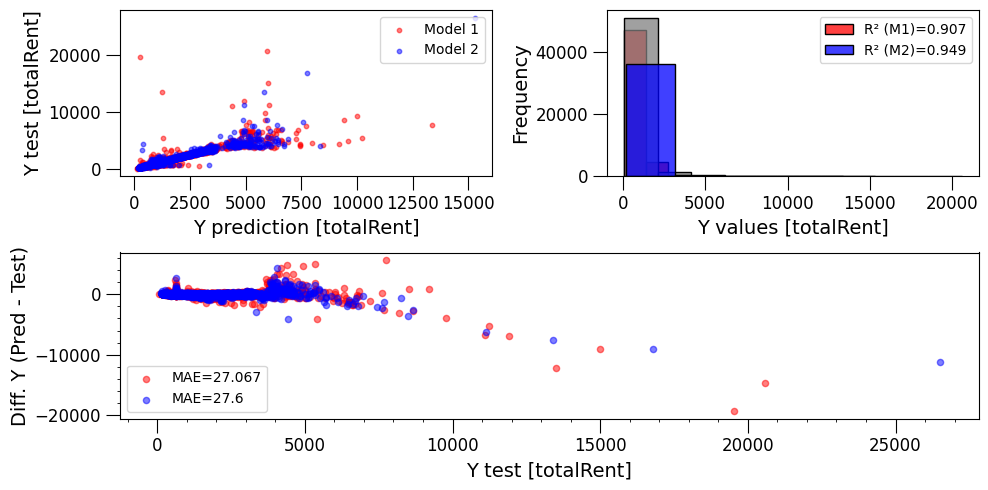

In [ ]:
fig=plt.figure(figsize=(10,5))
ax1=plt.subplot(2,2,1)
ax2=plt.subplot(2,2,2)
ax3=plt.subplot(2,1,2)
#ax3=plt.subplot(222)
#axes = axes.flatten()

# scatter plot:
df_predictions_1_sorted=df_predictions_1.sort_values(by='Actual_1')
df_predictions_2_sorted=df_predictions_2.sort_values(by='Actual_2')


ax1.scatter(df_predictions_1_sorted['Predicted'], df_predictions_1_sorted['Actual_1'], color='red', label='Model 1', s=10, alpha=0.5)
#ax1.plot(df_predictions_1_sorted['Predicted'], df_predictions_1_sorted['Actual_1'], color='red', label='Model 1')

ax1.scatter(df_predictions_2_sorted['Predicted'], df_predictions_2_sorted['Actual_2'], color='blue', label='Model 2', s=10, alpha=0.5)
ax1.set_xlabel('Y prediction [totalRent]', fontsize=14)
ax1.set_ylabel('Y test [totalRent]', fontsize=14)
ax1.legend(loc='upper right')

sns.histplot(y_pred_final1, bins=10, ax=ax2, color='red', label='R² (M1)=' + str(np.around(r2_final1, decimals=3)))
sns.histplot(y_test, bins=10,ax=ax2, color='gray')
sns.histplot(y_pred_2, bins=5,ax=ax2, color='blue', label='R² (M2)=' + str(np.around(r2_final2, decimals=3)))

ax2.set_xlabel('Y values [totalRent]', fontsize=14)
ax2.set_ylabel('Frequency', fontsize=14)
ax2.legend(loc='upper right')
plt.minorticks_on()

ax2.tick_params(axis='both', labelsize=12, size=10)
ax1.tick_params(axis='both', labelsize=12, size=10)


ax3.scatter(df_predictions_1_sorted['Actual_1'],df_predictions_1_sorted['Predicted'] - df_predictions_1_sorted['Actual_1'], color='red', s=20, alpha=0.5, label='MAE=' + str(np.round(mae_final1, decimals=3)))
ax3.scatter(df_predictions_2_sorted['Actual_2'],df_predictions_2_sorted['Predicted'] - df_predictions_2_sorted['Actual_2'], color='blue', s=20, alpha=0.5, label='MAE=' + str(np.round(mae_final2, decimals=3)))
ax3.set_xlabel('Y test [totalRent]', fontsize=14)
ax3.set_ylabel('Diff. Y (Pred - Test)', fontsize=14)
ax3.legend(loc='lower left')
plt.minorticks_on()

ax3.tick_params(axis='both', labelsize=12, size=10)
ax3.tick_params(axis='both', labelsize=12, size=10)


plt.tight_layout()

plt.savefig(path_files + 'Figure_result_comparison.png')

